## 导入库

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.nn import functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, random_split, DataLoader

from DTC import DTC

## 模型

In [2]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.res = nn.Linear(n_inputs, n_outputs)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = self.res(torch.permute(x,(0,2,1)))
        return out + torch.permute(res, (0,2,1))


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, dila = True, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            if dila:
                dilation_size = 2 ** i
            else:
                dilation_size = 1
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # self.u = nn.Linear(out_channels, num_cluster)
        self.network = nn.Sequential(*layers)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        X = []
        x = torch.permute(x, (0, 2, 1))
        for la in self.network:
            x = la(x)
            X.append(torch.permute(x, (0, 2, 1)))
        return torch.permute(x, (0, 2, 1)), X

In [3]:
class DRNN(nn.Module):

    def __init__(self, n_input, n_hiddens, dila=True, dropout=0, cell_type="RNN", batch_first=True):
        super().__init__()

        n_layers = len(n_hiddens)
        if dila:
            self.dilations = [2 ** i for i in range(n_layers)]
        else:
            self.dilations = [1] * n_layers
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hiddens[i], dropout=dropout)
            else:
                c = cell(n_hiddens[i-1], n_hiddens[i], dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers).cuda()

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])
            if self.batch_first:
                outputs.append(inputs.transpose(1, 0))
            else:
                outputs.append(inputs)
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, _ = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size, hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)
        return outputs, hidden

    def init_hidden(self, batch_size, hidden_dim):
        hidden = torch.zeros(batch_size, hidden_dim).cuda()
        if self.cell_type == "LSTM":
            memory = torch.zeros(batch_size, hidden_dim).cuda()
            return (hidden, memory)
        else:
            return hidden

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

    def _pad_inputs(self, inputs, n_steps, rate):
        is_even = (n_steps % rate) == 0

        if not is_even:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0), inputs.size(1),inputs.size(2)).cuda()
            inputs = torch.cat((inputs, zeros_)).cuda()
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]
        interleaved = torch.stack(blocks).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate, batchsize, dilated_outputs.size(2)).cuda()

        return interleaved

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            if self.cell_type == 'LSTM':
                c, m = self.init_hidden(batch_size * rate, hidden_size)
                hidden = (c.unsqueeze(0), m.unsqueeze(0))
            else:
                hidden = self.init_hidden(batch_size * rate, hidden_size).unsqueeze(0)

        dilated_outputs, hidden = cell(dilated_inputs, hidden)

        return dilated_outputs, hidden

In [4]:
class selfAttention(nn.Module):
    def __init__(self, num_attention_heads, input_size, hidden_size):
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "the hidden size %d is not a multiple of the number of attention heads"
                "%d" % (hidden_size, num_attention_heads)
            )
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size

        self.key_layer = nn.Linear(input_size, hidden_size)
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.inita()

    def inita(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
    def trans_to_multiple_heads(self, x):
        new_size = x.size()[ : -1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_size)
        return x.permute(0, 2, 1, 3)

    def forward(self, x):
        key = self.key_layer(x)
        query = self.query_layer(x)
        value = self.value_layer(x)

        key_heads = self.trans_to_multiple_heads(key)
        query_heads = self.trans_to_multiple_heads(query)
        value_heads = self.trans_to_multiple_heads(value)

        attention_scores = torch.matmul(query_heads, key_heads.permute(0, 1, 3, 2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        attention_probs = F.softmax(attention_scores, dim = -1)

        context = torch.matmul(attention_probs, value_heads)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_size = context.size()[ : -2] + (self.all_head_size , )
        context = context.view(*new_size)
        return context

In [5]:
class encoder(nn.Module):
    def __init__(self, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, combination=False, base_type=0):
        super().__init__()
        self.combination = combination
        self.base_type = base_type
        if base_type == 0:
            self.feature = TemporalConvNet(num_inputs, num_channels)
        else:
            self.feature = DRNN(num_inputs, num_channels)

        self.mlp = nn.Linear(sum(num_channels), num_channels[-1])
        self.rnn = nn.RNN(hidden_dim, rnn_dim, batch_first=True)
        self.attention = selfAttention(num_attention_heads, num_channels[-1], hidden_dim)

    def forward(self, x):
        feature, features = self.feature(x)
        if self.combination:
            feature = self.mlp(torch.concat(features, dim=-1))
        feature = self.attention(feature)
        feature, _ = self.rnn(feature)
        # feature = self.attention(feature)
        return feature

In [6]:
class Baseline(nn.Module):
    def __init__(self, base_encoder, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, m=0.999, T=0.07, dila=True, combination=True, base_type=0):
        super().__init__()
        self.m = m
        self.T = T

        self.encoder = base_encoder(num_inputs, num_channels, rnn_dim, num_attention_heads, hidden_dim, combination, base_type).cuda()

        channels = num_channels.copy()
        channels.reverse()
        channels.append(num_inputs)
        if self.encoder.base_type == 0:
            self.decoder = TemporalConvNet(rnn_dim, channels, dila=False)
        else:
            self.decoder = DRNN(rnn_dim, channels, dila=False)
            # decoder = []
            # for i in range(len(channels)-1):
            #   decoder.append(nn.GRU(channels[i], channels[i+1], batch_first=True))
            # self.decoder = nn.Sequential(*decoder)

        # self.mlp = nn.Sequential(nn.Linear(rnn_dim, 2 * rnn_dim), nn.ReLU(), nn.Linear(2 * rnn_dim, rnn_dim))


    def forward(self, xh):
        hs = self.encoder(xh)
        return hs

    def fit(self, fh):
        hs = self(fh)
        # print(hs.shape)
        # h_n = hs[:,-1,:].squeeze()
        fh_d,_ = self.decoder(hs)
        # print(fh.shape, fh_d.shape)
        loss = torch.mean(torch.sum(torch.pow(fh - fh_d, 2), dim=-1))
        return loss

In [8]:
# 模型1：tcn
m1 = Baseline(encoder, base_type=0, combination=False)
# 模型2：tcn + combination
m2 = Baseline(encoder, base_type=0, combination=True)
# 模型3：tcn + distance calculation
params3 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=False
)
m3 = DTC(**params3)
# 模型4：tcn + combination + distance calculation
params4 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=True
)
m4 = DTC(**params4)
# 模型5：drnn
m5 = Baseline(encoder, base_type=1, combination=False)
# 模型6：drnn + combination
m6 = Baseline(encoder, base_type=1, combination=True)
# 模型7：drnn + distance calculation
params7 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=False
)
m7 = DTC(**params7)
# 模型8：drnn + combination + distance calculation
params8 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=True
)
m8 = DTC(**params8)

## 数据

In [9]:
data = pd.read_csv("fishing.csv")

# 对标签进行处理，捕捞标签为1，行驶标签为0
Lab = data["label"].values

for (i,lab) in enumerate(Lab):
    if lab.endswith("sailing"):
        Lab[i] = 0
    else:
        Lab[i] = 1

data["label"] = Lab

ids = data["id"].unique()
L = [len(data[data["id"]==iid]) for iid in ids]

In [10]:
D = []
# Lab = []
for iid, l in zip(ids,L):
    # 按照ID对数据进行划分
    d = data.loc[data["id"]==iid, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]]
    d.reset_index(drop=True, inplace=True)


    # 下面需要按照时间差对轨迹进行分割
    # 时间差设置为10分钟，即600秒
    inds = np.argwhere(d["time_gap"].values > 600)
    inds = [ii[0] for ii in inds]
    if len(inds) > 0:
        # inds = inds[0]
        # d.loc[inds, ["signed_turn", "distance_gap", "euc_speed", "time_gap"]] = np.array([np.mean(d["signed_turn"]), np.mean(d["distance_gap"]), np.mean(d["euc_speed"]), np.mean(d["time_gap"])])
        D.append(d.loc[0:inds[0]-1, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
        for i in range(len(inds)-1):
            D.append(d.loc[inds[i]:inds[i]-1, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
        D.append(d.loc[inds[-1]:, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
    else:
        D.append(d.loc[:, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
    # for i in range(0, l-500, 500):
    #     D.append(d.loc[i:i+500-1,["signed_turn", "distance_gap", "euc_speed", "distanceToShore"]].values)
    #     Lab.append(d.loc[i:i+500-1,"label"].values)
    # D.append(d.loc[i+500:,["signed_turn", "distance_gap", "euc_speed", "distanceToShore"]].values)
    # Lab.append(d.loc[i+500:,"label"])
D = [d for d in D if len(d) > 1000]
for d in D:
    d.reset_index(drop=True, inplace=True)
L = [len(d) for d in D]

for d in D:
    d.loc[d["euc_speed"] > 20, "euc_speed"] = 20
    d["euc_speed"] = d["euc_speed"] * 0.5144
    d.loc[d["distance_gap"] > 200, "distance_gap"] = 200
    d["signed_turn"] = d["signed_turn"] / 180 * np.pi

In [11]:
Fs = []
Lab = []
for d in D:
    # 已有特征
    speed = d["euc_speed"].values[1:]
    signed_turn = d["signed_turn"].values[1:]
    distance_gap = d["distance_gap"].values[1:]
    distanceToShore = d["distanceToShore"].values

    time_gap = d["time_gap"].values[1:]
    # 计算特征
    speed_gap = d["euc_speed"].diff().values[1:]
    speed_gap_ratio = speed_gap / time_gap
    distance_gap_ratio = distance_gap / time_gap
    signed_turn_ratio = signed_turn / time_gap
    # distanceToShore_ratio = distanceToShore[1:] / np.cumsum(time_gap)
    distanceToShore_gap = np.diff(distanceToShore) / time_gap

    # print(len(speed.tolist()), len(signed_turn.tolist()), len(distance_gap.tolist()), len(distanceToShore.tolist()), len(speed_gap.tolist()), len(speed_gap_ratio.tolist()))
    # print(len(distance_gap_ratio.tolist()), len(signed_turn_ratio.tolist()), len(distanceToShore_ratio.tolist()), len(distanceToShore_gap.tolist()))

    Fs.append(np.array([speed.tolist(), signed_turn.tolist(), distance_gap.tolist(), distanceToShore[1:].tolist(), speed_gap.tolist(),
                       speed_gap_ratio.tolist(), distance_gap_ratio.tolist(), signed_turn_ratio.tolist(),
                       distanceToShore_gap.tolist()]).transpose(1,0))
    Lab.append(d["label"].values[1:])

L = [len(f) for f in Fs]
V = np.concatenate(Fs, axis=0)

Fs = [(fs - np.mean(V, axis=0)) / (np.std(V, axis=0)) for fs in Fs]

In [12]:
# 下面我们对数据进行采样，参数为时间窗口的长度，设置时间窗口，每一次在一个点的左右采样。因为全部进行采样的话耗费的内存过大，因此我采用时间步长，间隔step点再进行采样。

def sample(feature, lab, window_size):
    Flag = []
    Fs_p = []
    # Fs_f = []
    L_p = []
    # L_f = []
    P = []
    Lab_p = []
    # Lab_f = []
    for i in range(len(feature)):
        f = feature[i]
        l = lab[i]
        p = []
        for j in range(window_size, l.shape[0]-window_size, window_size):
            Fs_p.append(f[j-window_size:j,:])
            L_p.append(l[j-window_size:j])
            if len(np.unique(l[j-window_size:j])) == 2:
                if np.sum(l[j-window_size:j]==0) > np.sum(l[j-window_size:j]==1):
                    Lab_p.append(0)
                else:
                    Lab_p.append(1)
            else:
                if np.unique(l[j-window_size:j]) == 0:
                    Lab_p.append(0)
                else:
                    Lab_p.append(1)
            Flag.append(i)
            p.append(j)
        P.append(p)
    return Fs_p, L_p, Flag, P, np.array(Lab_p)

# Flag表示原先数据属于第几个时间序列

In [13]:
class TrajDataset(Dataset):
    def __init__(self, F, L, T):
        self.F = pad_sequence(F, batch_first=True, padding_value=0)
        self.L = L
        self.T = T
    def __len__(self):
        return len(self.F)
    def __getitem__(self, index):
        return self.F[index], self.L[index], self.T[index]

### 片段长度100

In [14]:
Fs_p_100, L_p_100, Flag_100, P_100, Lab_p_100 = sample(Fs, Lab, 100)

Fs_p_100 = np.stack(Fs_p_100, axis=0)
L_p_100 = np.stack(L_p_100, axis=0)

Fs_p_100 = torch.tensor(Fs_p_100)
L_p_100 =torch.tensor(L_p_100.astype(np.int32))
Lab_p_100 = torch.tensor(Lab_p_100.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_100 = Fs_p_100.float()


DD_100 = []
for i, (d, p) in enumerate(zip(D, P_100)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_100.append(d_)
DD_100 = pd.concat(DD_100)
DD_100.reset_index(drop=True, inplace=True)

T_100 = torch.tensor(DD_100["label"].values.astype("int")).reshape(-1, 100)

dataset_100 = TrajDataset(Fs_p_100, L_p_100, T_100)
train_size_100 = int(0.8 * len(dataset_100))
val_size_100 = len(dataset_100) - train_size_100

# 使用 random_split 分割数据集
train_dataset_100, val_dataset_100 = random_split(dataset_100, [train_size_100, val_size_100])

# 创建 DataLoader
train_loader_100 = DataLoader(train_dataset_100, batch_size=2000, shuffle=True)
val_loader_100 = DataLoader(val_dataset_100, batch_size=2000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_100 = TrajDataset(Fs_p_100, L_p_100, T_100)
all_loader_100 = DataLoader(all_dataset_100, batch_size=2000, shuffle=False)

In [15]:
np.save("results5/index_100.npy", val_loader_100.dataset.indices)

### 片段长度80

In [14]:
Fs_p_80, L_p_80, Flag_80, P_80, Lab_p_80 = sample(Fs, Lab, 80)

Fs_p_80 = np.stack(Fs_p_80, axis=0)
L_p_80 = np.stack(L_p_80, axis=0)

Fs_p_80 = torch.tensor(Fs_p_80)
L_p_80 =torch.tensor(L_p_80.astype(np.int32))
Lab_p_80 = torch.tensor(Lab_p_80.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_80 = Fs_p_80.float()

DD_80 = []
for i, (d, p) in enumerate(zip(D, P_80)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_80.append(d_)
DD_80 = pd.concat(DD_80)
DD_80.reset_index(drop=True, inplace=True)

T_80 = torch.tensor(DD_80["label"].values.astype("int")).reshape(-1, 80)

dataset_80 = TrajDataset(Fs_p_80, L_p_80, T_80)
train_size_80 = int(0.8 * len(dataset_80))
val_size_80 = len(dataset_80) - train_size_80

# 使用 random_split 分割数据集
train_dataset_80, val_dataset_80 = random_split(dataset_80, [train_size_80, val_size_80])
# 创建 DataLoader
train_loader_80 = DataLoader(train_dataset_80, batch_size=2000, shuffle=True)
val_loader_80 = DataLoader(val_dataset_80, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_80 = TrajDataset(Fs_p_80, L_p_80, T_80)
all_loader_80 = DataLoader(all_dataset_80, batch_size=2000, shuffle=False)

In [57]:
np.save("results3/index_80.npy", val_loader_80.dataset.indices)

### 片段长度60

In [15]:
Fs_p_60, L_p_60, Flag_60, P_60, Lab_p_60 = sample(Fs, Lab, 60)

Fs_p_60 = np.stack(Fs_p_60, axis=0)
L_p_60 = np.stack(L_p_60, axis=0)

Fs_p_60 = torch.tensor(Fs_p_60)
L_p_60 =torch.tensor(L_p_60.astype(np.int32))
Lab_p_60 = torch.tensor(Lab_p_60.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_60 = Fs_p_60.float()

DD_60 = []
for i, (d, p) in enumerate(zip(D, P_60)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_60.append(d_)
DD_60 = pd.concat(DD_60)
DD_60.reset_index(drop=True, inplace=True)

T_60 = torch.tensor(DD_60["label"].values.astype("int")).reshape(-1, 60)

dataset_60 = TrajDataset(Fs_p_60, L_p_60, T_60)
train_size_60 = int(0.8 * len(dataset_60))
val_size_60 = len(dataset_60) - train_size_60

# 使用 random_split 分割数据集
train_dataset_60, val_dataset_60 = random_split(dataset_60, [train_size_60, val_size_60])

# 创建 DataLoader
train_loader_60 = DataLoader(train_dataset_60, batch_size=2000, shuffle=True)
val_loader_60 = DataLoader(val_dataset_60, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_60 = TrajDataset(Fs_p_60, L_p_60, T_60)
all_loader_60 = DataLoader(all_dataset_60, batch_size=2000, shuffle=False)

In [58]:
np.save("results3/index_60.npy", val_loader_60.dataset.indices)

### 片段长度40

In [16]:
Fs_p_40, L_p_40, Flag_40, P_40, Lab_p_40 = sample(Fs, Lab, 40)

Fs_p_40 = np.stack(Fs_p_40, axis=0)
L_p_40 = np.stack(L_p_40, axis=0)

Fs_p_40 = torch.tensor(Fs_p_40)
L_p_40 =torch.tensor(L_p_40.astype(np.int32))
Lab_p_40 = torch.tensor(Lab_p_40.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_40 = Fs_p_40.float()

DD_40 = []
for i, (d, p) in enumerate(zip(D, P_40)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_40.append(d_)
DD_40 = pd.concat(DD_40)
DD_40.reset_index(drop=True, inplace=True)

T_40 = torch.tensor(DD_40["label"].values.astype("int")).reshape(-1, 40)

dataset_40 = TrajDataset(Fs_p_40, L_p_40, T_40)
train_size_40 = int(0.8 * len(dataset_40))
val_size_40 = len(dataset_40) - train_size_40

# 使用 random_split 分割数据集
train_dataset_40, val_dataset_40 = random_split(dataset_40, [train_size_40, val_size_40])
# 创建 DataLoader
train_loader_40 = DataLoader(train_dataset_40, batch_size=2000, shuffle=True)
val_loader_40 = DataLoader(val_dataset_40, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_40 = TrajDataset(Fs_p_40, L_p_40, T_40)
all_loader_40 = DataLoader(all_dataset_40, batch_size=2000, shuffle=False)

In [59]:
np.save("results3/index_40.npy", val_loader_40.dataset.indices)

### 片段长度30

In [17]:
Fs_p_30, L_p_30, Flag_30, P_30, Lab_p_30 = sample(Fs, Lab, 30)

Fs_p_30 = np.stack(Fs_p_30, axis=0)
L_p_30 = np.stack(L_p_30, axis=0)

Fs_p_30 = torch.tensor(Fs_p_30)
L_p_30 =torch.tensor(L_p_30.astype(np.int32))
Lab_p_30 = torch.tensor(Lab_p_30.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_30 = Fs_p_30.float()

DD_30 = []
for i, (d, p) in enumerate(zip(D, P_30)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_30.append(d_)
DD_30 = pd.concat(DD_30)
DD_30.reset_index(drop=True, inplace=True)

T_30 = torch.tensor(DD_30["label"].values.astype("int")).reshape(-1, 30)

dataset_30 = TrajDataset(Fs_p_30, L_p_30, T_30)
train_size_30 = int(0.8 * len(dataset_30))
val_size_30 = len(dataset_30) - train_size_30

# 使用 random_split 分割数据集
train_dataset_30, val_dataset_30 = random_split(dataset_30, [train_size_30, val_size_30])
# 创建 DataLoader
train_loader_30 = DataLoader(train_dataset_30, batch_size=2000, shuffle=True)
val_loader_30 = DataLoader(val_dataset_30, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_30 = TrajDataset(Fs_p_30, L_p_30, T_30)
all_loader_30 = DataLoader(all_dataset_30, batch_size=2000, shuffle=False)

In [60]:
np.save("results3/index_30.npy", val_loader_30.dataset.indices)

### 片段长度20

In [18]:
Fs_p_20, L_p_20, Flag_20, P_20, Lab_p_20 = sample(Fs, Lab, 20)

Fs_p_20 = np.stack(Fs_p_20, axis=0)
L_p_20 = np.stack(L_p_20, axis=0)

Fs_p_20 = torch.tensor(Fs_p_20)
L_p_20 =torch.tensor(L_p_20.astype(np.int32))
Lab_p_20 = torch.tensor(Lab_p_20.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_20 = Fs_p_20.float()

DD_20 = []
for i, (d, p) in enumerate(zip(D, P_20)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_20.append(d_)
DD_20 = pd.concat(DD_20)
DD_20.reset_index(drop=True, inplace=True)

T_20 = torch.tensor(DD_20["label"].values.astype("int")).reshape(-1, 20)

dataset_20 = TrajDataset(Fs_p_20, L_p_20, T_20)
train_size_20 = int(0.8 * len(dataset_20))
val_size_20 = len(dataset_20) - train_size_20

# 使用 random_split 分割数据集
train_dataset_20, val_dataset_20 = random_split(dataset_20, [train_size_20, val_size_20])
# 创建 DataLoader
train_loader_20 = DataLoader(train_dataset_20, batch_size=2000, shuffle=True)
val_loader_20 = DataLoader(val_dataset_20, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_20 = TrajDataset(Fs_p_20, L_p_20, T_20)
all_loader_20 = DataLoader(all_dataset_20, batch_size=2000, shuffle=False)

In [61]:
np.save("results3/index_20.npy", val_loader_20.dataset.indices)

### 片段长度10

In [19]:
Fs_p_10, L_p_10, Flag_10, P_10, Lab_p_10 = sample(Fs, Lab, 10)

Fs_p_10 = np.stack(Fs_p_10, axis=0)
L_p_10 = np.stack(L_p_10, axis=0)

Fs_p_10 = torch.tensor(Fs_p_10)
L_p_10 =torch.tensor(L_p_10.astype(np.int32))
Lab_p_10 = torch.tensor(Lab_p_10.astype(np.int32))
# Flag = torch.tensor(np.array(Flag).astype(np.int32))
Fs_p_10 = Fs_p_10.float()

DD_10 = []
for i, (d, p) in enumerate(zip(D, P_10)):
    d_ = d.copy()[:p[-1]]
    d_["MMSI"] = i
    DD_10.append(d_)
DD_10 = pd.concat(DD_10)
DD_10.reset_index(drop=True, inplace=True)

T_10 = torch.tensor(DD_10["label"].values.astype("int")).reshape(-1, 10)

dataset_10 = TrajDataset(Fs_p_10, L_p_10, T_10)
train_size_10 = int(0.8 * len(dataset_10))
val_size_10 = len(dataset_10) - train_size_10

# 使用 random_split 分割数据集
train_dataset_10, val_dataset_10 = random_split(dataset_10, [train_size_10, val_size_10])
# 创建 DataLoader
train_loader_10 = DataLoader(train_dataset_10, batch_size=2000, shuffle=True)
val_loader_10 = DataLoader(val_dataset_10, batch_size=1000, shuffle=False)

# 所有数据整合, 查看模型结果的时候使用
all_dataset_10 = TrajDataset(Fs_p_10, L_p_10, T_10)
all_loader_10 = DataLoader(all_dataset_10, batch_size=2000, shuffle=False)

In [62]:
np.save("results3/index_10.npy", val_loader_10.dataset.indices)

## 模型1

### 片段长度100

#### 训练

In [16]:
m1_100 = m1.cuda()

In [17]:
optimizer1_100 = optim.Adam(m1_100.parameters(), lr=1e-3, weight_decay=1e-1)

/root/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
Loss1_100 = []

In [20]:
m1_100.train()
for i in range(100):
    Lo1_100 = 0
    print(i)
    for f,_,_ in train_loader_100:
        optimizer1_100.zero_grad()
        loss1_100 = m1_100.fit(f.float().cuda())
        loss1_100.backward()
        optimizer1_100.step()
        Lo1_100 += loss1_100.item()
    Loss1_100.append(Lo1_100 / len(train_loader_100))
    print(i, Loss1_100[-1])

0
0 1.6332311034202576
1
1 1.6314094364643097
2
2 1.6154912114143372
3
3 1.6218938529491425
4
4 1.6149228811264038
5
5 1.6191587150096893
6
6 1.6040086150169373
7
7 1.598738819360733
8
8 1.5904336273670197
9
9 1.5780622959136963
10
10 1.5746555924415588
11
11 1.584856003522873
12
12 1.5714183151721954
13
13 1.5580424666404724
14
14 1.5564140379428864
15
15 1.551462471485138
16
16 1.5523415505886078
17
17 1.5483867526054382
18
18 1.5461487174034119
19
19 1.5585604906082153
20
20 1.550530195236206
21
21 1.5248858034610748
22
22 1.5325295329093933
23
23 1.5303230285644531
24
24 1.5165888667106628
25
25 1.515106201171875
26
26 1.5016630291938782
27
27 1.5104700922966003
28
28 1.5048365592956543
29
29 1.508149802684784
30
30 1.5060442388057709
31
31 1.497242957353592
32
32 1.4976204335689545
33
33 1.4759812355041504
34
34 1.4787875711917877
35
35 1.4714508652687073
36
36 1.4676912128925323
37
37 1.467144101858139
38
38 1.4601150751113892
39
39 1.4447144567966461
40
40 1.4463552236557007
41


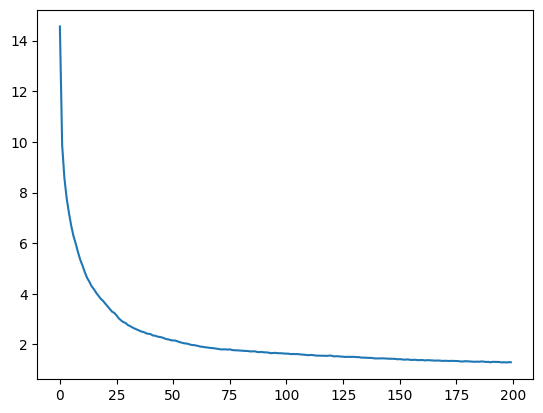

In [21]:
plt.plot(Loss1_100)

In [22]:
torch.save(m1_100.state_dict(), "results5/m1_100.pkl")

In [26]:
# m1_100.load_state_dict(torch.load("para_origin/m1_100_1.pkl"))

In [23]:
V1_100 = []
V1_100_ = []
L1_100 = []
m1_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v1_100 = m1_100(f.float().cuda())
        for i in range(v1_100.shape[0]):
            V1_100.append(v1_100[i,-1,:].cpu().detach().numpy())
            V1_100_.append(v1_100[i,:,:].cpu().detach().numpy())
            L1_100.append(l[i])
V1_100 = np.stack(V1_100)
V1_100_ = np.stack(V1_100_)
L1_100 = np.stack(L1_100).reshape(-1)

In [24]:
kmeans1_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_100.fit(V1_100)
label1_100 = kmeans1_100.predict(V1_100)

In [25]:
kmeans1_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_100.fit(V1_100_.reshape(-1, 16))
label1_100_ = kmeans1_100.predict(V1_100_.reshape(-1, 16))

In [26]:
labels1_100 = np.concatenate([[i] * 100 for i in label1_100])

In [28]:
np.sum(labels1_100 != L1_100) / len(L1_100), np.sum(label1_100_ != L1_100) / len(L1_100)

(0.9238481646879425, 0.9267966452456159)

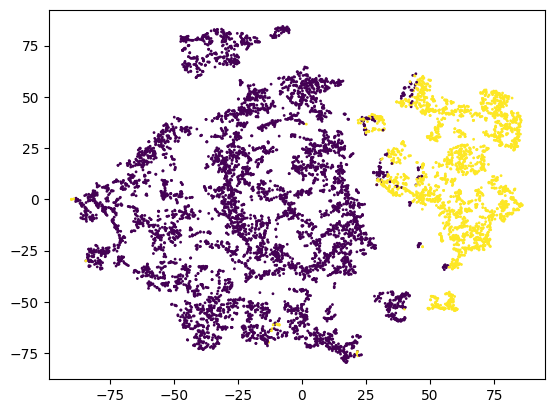

In [29]:
tsne1_100 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne1_100 = tsne1_100.fit_transform(V1_100)
plt.scatter(X_tsne1_100[:,0], X_tsne1_100[:,1],s=1,c=label1_100)

In [30]:
np.save("results5/m_1_100.npy", np.stack(V1_100))
np.save("results5/m_1_100_all.npy", np.stack(V1_100_))
np.save("results5/tru_1_100.npy", L1_100)

In [33]:
# 提取混合的片段
label_100 = L1_100.copy()
label_100 = label_100.reshape(-1, 100)

indexs = []
for i in range(label_100.shape[0]):
    if len(np.unique(label_100[i])) == 2:
        indexs.append(i)

In [31]:
.shape

(918100,)

In [34]:
# 计算距离
P = np.sum(label_100.reshape(-1,100)[indexs,:] == 0, axis=1) / 100
# C = np.sum(label_100[indexs,:] == 0, axis=1) > 50
def dist(f, center=None, com=False):
    if ~com:
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(f)
        lp = kmeans.predict(f)
        center = kmeans.cluster_centers_
    else:
        lp = np.argmin(np.sum(np.power(f[:, np.newaxis,:] - center[np.newaxis,:,:], 2), axis=-1), axis=-1)
    
    if np.sum(lp==0) > np.sum(lp==1):
        fc = center[0]
        sc = center[1]
        c = lp[indexs]
    else:
        fc = center[1]
        sc = center[0]
        c = ~lp[indexs]
    fm = f[indexs,:]
    d = np.sqrt(np.sum(np.power(fm - fc, 2), axis=-1)) / (np.sqrt(np.sum(np.power(fm - fc, 2), axis=-1)) + np.sqrt(np.sum(np.power(fm - sc, 2), axis=-1)))
    return d, c

In [35]:
d, c = dist(np.stack(V1_100))

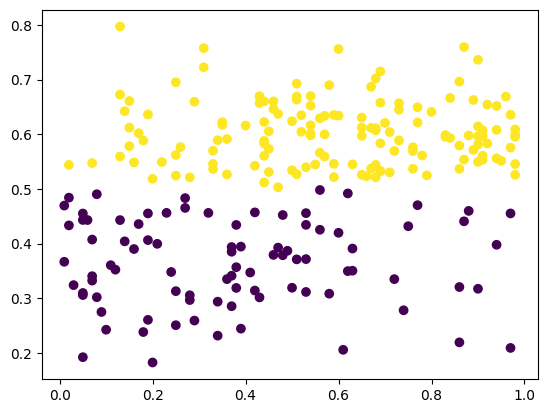

In [36]:
plt.scatter(P, d, c=c)

### 片段长度 60

#### 训练

In [170]:
m1_60 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [173]:
optimizer1_60 = optim.Adam(m1_60.parameters(), lr=1e-3, weight_decay=1e-1)

In [172]:
Loss1_60 = []

In [174]:
m1_60.train()
for i in range(100):
    Lo1_60 = 0
    print(i)
    for f,_,_ in train_loader_60:
        optimizer1_60.zero_grad()
        loss1_60 = m1_60.fit(f.float().cuda())
        loss1_60.backward()
        optimizer1_60.step()
        Lo1_60 += loss1_60.item()
    Loss1_60.append(Lo1_60 / len(train_loader_60))
    print(i, Loss1_60[-1])

0
0 10.731351171221052
1
1 7.824241025107248
2
2 6.70427622113909
3
3 6.019121170043945
4
4 5.478117397853306
5
5 5.086644172668457
6
6 4.797970022474017
7
7 4.47714376449585
8
8 4.198325463703701
9
9 4.0710413455963135
10
10 3.67565655708313
11
11 3.4216611044747487
12
12 3.2348275184631348
13
13 3.060143675122942
14
14 2.9289604936327254
15
15 2.8035528319222585
16
16 2.643500259944371
17
17 2.5320613043648854
18
18 2.527412244251796
19
19 2.4258339745657787
20
20 2.3311116014208113
21
21 2.2975076947893416
22
22 2.2090520518166676
23
23 2.195770706449236
24
24 2.160286716052464
25
25 2.2155918053218295
26
26 2.0840891088758196
27
27 2.092233555657523
28
28 2.0693872485842024
29
29 2.0406225408826555
30
30 2.0394817079816545
31
31 2.0459293127059937
32
32 2.0847138166427612
33
33 2.0098818029676164
34
34 1.9648309435163225
35
35 1.9345459938049316
36
36 1.926874348095485
37
37 1.9405511447361536
38
38 1.9226034198488509
39
39 1.8673797164644514
40
40 1.8872871228626795
41
41 1.894319

In [179]:
torch.save(m1_60.state_dict(), "results3/m1_60.pkl")

In [164]:
# m1_60.load_state_dict(torch.load("results3/m1_60.pkl"))

In [181]:
V1_60 = []
L1_60 = []
V1_60_ = []
m1_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v1_60 = m1_60(f.float().cuda())
        for i in range(v1_60.shape[0]):
            V1_60.append(v1_60[i,-1,:].cpu().detach().numpy())
            V1_60_.append(v1_60[i,:,:].cpu().detach().numpy())
            L1_60.append(l[i])
V1_60 = np.stack(V1_60)
V1_60_ = np.stack(V1_60_)
L1_60 = np.stack(L1_60).reshape(-1)

In [182]:
kmeans1_60 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_60.fit(V1_60)
label1_60 = kmeans1_60.predict(V1_60)

kmeans1_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_60.fit(V1_60_.reshape(-1, 16))
label1_60_ = kmeans1_60.predict(V1_60_.reshape(-1, 16))

In [183]:
labels1_60 = np.concatenate([[i] * 60 for i in label1_60])

In [185]:
np.sum(labels1_60 != L1_60) / len(L1_60), np.sum(label1_60_ != L1_60) / len(L1_60)

(0.925187296241121, 0.9242686270699743)

In [41]:
# torch.save(m1_60.state_dict(), "para_origin/m1_60.pkl")

In [186]:
np.save("results3/m_1_60.npy", np.stack(V1_60))
np.save("results3/m_1_60_all.npy", np.stack(V1_60_))
np.save("results3/tru_1_60.npy", L1_60)

### 片段长为30

#### 训练

In [105]:
m1_30 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [115]:
optimizer1_30 = optim.Adam(m1_30.parameters(), lr=1e-4, weight_decay=1e-3)

In [107]:
Loss1_30 = []

In [120]:
m1_30.train()
for i in range(10):
    Lo1_30 = 0
    print(i)
    for f,_,_ in train_loader_30:
        optimizer1_30.zero_grad()
        loss1_30 = m1_30.fit(f.float().cuda())
        loss1_30.backward()
        optimizer1_30.step()
        Lo1_30 += loss1_30.item()
    Loss1_30.append(Lo1_30 / len(train_loader_30))
    print(i, Loss1_30[-1])

0
0 0.2310989613716419
1
1 0.23079154926996964
2
2 0.22764627864727607
3
3 0.2309659501680961
4
4 0.23111801881056565
5
5 0.227687262571775
6
6 0.2295565249828192
7
7 0.229280581841102
8
8 0.22794080009827247
9
9 0.22927678662997025


In [125]:
m1_30.load_state_dict(torch.load("results3/m1_30.pkl"))

<All keys matched successfully>

In [126]:
# torch.save(m1_30.state_dict(), "results3/m1_30.pkl")

In [132]:
V1_30 = []
V1_30_ = []
L1_30 = []
m1_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v1_30 = m1_30(f.float().cuda())
        for i in range(v1_30.shape[0]):
            V1_30.append(v1_30[i,-1,:].cpu().detach().numpy())
            V1_30_.append(v1_30[i,:,:].cpu().detach().numpy())
            L1_30.append(l[i])
V1_30 = np.stack(V1_30)
V1_30_ = np.stack(V1_30_)
L1_30 = np.stack(L1_30).reshape(-1)

In [133]:
kmeans1_30 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_30.fit(V1_30)
label1_30 = kmeans1_30.predict(V1_30)

labels1_30 = np.concatenate([[i] * 30 for i in label1_30])

kmeans1_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_30.fit(V1_30_.reshape(-1, 16))
label1_30_ = kmeans1_30.predict(V1_30_.reshape(-1, 16))

In [187]:
np.sum(labels1_30 != L1_30) / len(L1_30), np.sum(label1_30_ != L1_30) / len(L1_30)

(0.9283112955634913, 0.9276249611255885)

In [135]:
np.save("results3/m_1_30.npy", np.stack(V1_30))
np.save("results3/m_1_30_all.npy", np.stack(V1_30_))
np.save("results3/tru_1_30.npy", L1_30)

### 片段为20

#### 训练

In [188]:
m1_20 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [190]:
optimizer1_20 = optim.Adam(m1_20.parameters(), lr=1e-3, weight_decay=1e-3)

In [191]:
Loss1_20 = []

In [192]:
m1_20.train()
for i in range(100):
    Lo1_20 = 0
    print(i)
    for f,_,_ in train_loader_20:
        optimizer1_20.zero_grad()
        loss1_20 = m1_20.fit(f.float().cuda())
        loss1_20.backward()
        optimizer1_20.step()
        Lo1_20 += loss1_20.item()
    Loss1_20.append(Lo1_20 / len(train_loader_20))
    print(i, Loss1_20[-1])

0
0 11.798521393223814
1
1 7.0354937754179305
2
2 5.959124765898052
3
3 5.133591400949578
4
4 4.431621049579821
5
5 3.8106220521424947
6
6 3.2806794768885563
7
7 2.877149230555484
8
8 2.5762818110616585
9
9 2.336299839772676
10
10 2.1522933370188664
11
11 1.9788688609474583
12
12 1.840342873021176
13
13 1.714363041676973
14
14 1.6038350180575722
15
15 1.5088407177674144
16
16 1.426354954117223
17
17 1.3497798882032697
18
18 1.282236607451188
19
19 1.2158923400075812
20
20 1.1587771428258795
21
21 1.102263143188075
22
22 1.0472446585956372
23
23 1.0107617629201788
24
24 0.9725257252392016
25
25 0.9286435371951053
26
26 0.8889318798717699
27
27 0.8501376509666443
28
28 0.8180550117241708
29
29 0.7874656100022165
30
30 0.7517140256731134
31
31 0.724149111070131
32
32 0.7018157526066429
33
33 0.6687920250390705
34
34 0.6482720939736617
35
35 0.6295131570414493
36
36 0.604260830502761
37
37 0.5824768825581199
38
38 0.5643179291173032
39
39 0.5416745057231501
40
40 0.5252609754863539
41
41 0

In [193]:
# m1_20.load_state_dict(torch.load("para_origin/m1_20.pkl"))

In [200]:
V1_20 = []
V1_20_ = []
L1_20 = []
m1_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v1_20 = m1_20(f.float().cuda())
        for i in range(v1_20.shape[0]):
            V1_20.append(v1_20[i,-1,:].cpu().detach().numpy())
            V1_20_.append(v1_20[i,:,:].cpu().detach().numpy())
            L1_20.append(l[i])
V1_20 = np.stack(V1_20)
V1_20_ = np.stack(V1_20_)
L1_20 = np.stack(L1_20).reshape(-1)

In [201]:
kmeans1_20 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_20.fit(V1_20)
label1_20 = kmeans1_20.predict(V1_20)

labels1_20 = np.concatenate([[i] * 20 for i in label1_20])

kmeans1_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_20.fit(V1_20_.reshape(-1, 16))
label1_20_ = kmeans1_20.predict(V1_20_.reshape(-1, 16))

In [203]:
np.sum(labels1_20 != L1_20) / len(L1_20), np.sum(label1_20_ != L1_20) / len(L1_20)

(0.9255211008388975, 0.9258838383838384)

In [204]:
# torch.save(m1_20.state_dict(), "results3/m1_20.pkl")

In [205]:
np.save("results3/m_1_20.npy", np.stack(V1_20))
np.save("results3/m_1_20_all.npy", np.stack(V1_20_))
np.save("results3/tru_1_20.npy", L1_20)

### 片段为10

#### 训练

In [227]:
m1_10 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [228]:
optimizer1_10 = optim.Adam(m1_10.parameters(), lr=1e-3, weight_decay=1e-2)

In [229]:
Loss1_10 = []

In [230]:
m1_10.train()
for i in range(100):
    Lo1_10 = 0
    print(i)
    for f,_,_ in train_loader_10:
        optimizer1_10.zero_grad()
        loss1_10 = m1_10.fit(f.float().cuda())
        loss1_10.backward()
        optimizer1_10.step()
        Lo1_10 += loss1_10.item()
    Loss1_10.append(Lo1_10 / len(train_loader_10))
    print(i, Loss1_10[-1])

0
0 8.588842668031392
1
1 4.926411666368184
2
2 3.235130604944731
3
3 2.3455037631486593
4
4 1.9141659862116764
5
5 1.654085265962701
6
6 1.469993886194731
7
7 1.3440124267025997
8
8 1.242286675854733
9
9 1.1611443036480953
10
10 1.0919834798888157
11
11 1.0351258657480542
12
12 0.9705187882247724
13
13 0.9068230923853422
14
14 0.8424330510591206
15
15 0.7781568263706408
16
16 0.7246207108623103
17
17 0.6782274324642984
18
18 0.6382294061936831
19
19 0.6036417217631089
20
20 0.5710530375179491
21
21 0.5439402931614926
22
22 0.520026539501391
23
23 0.5017369428747579
24
24 0.48719676544791773
25
25 0.46910314967757777
26
26 0.45475075040992935
27
27 0.44731196604276957
28
28 0.4356366897884168
29
29 0.4281545830400367
30
30 0.42130024260596227
31
31 0.4111319160775134
32
32 0.4035805173610386
33
33 0.39544362065039185
34
34 0.3897187231402648
35
35 0.38299149745389033
36
36 0.37741611584236745
37
37 0.37487658074027613
38
38 0.36858903499026047
39
39 0.3616032286694175
40
40 0.357787532

In [235]:
torch.save(m1_10.state_dict(), "results3/m1_10.pkl")

In [237]:
V1_10 = []
V1_10_ = []
L1_10 = []
m1_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v1_10 = m1_10(f.float().cuda())
        for i in range(v1_10.shape[0]):
            V1_10.append(v1_10[i,-1,:].cpu().detach().numpy())
            V1_10_.append(v1_10[i,:,:].cpu().detach().numpy())
            L1_10.append(l[i])
V1_10 = np.stack(V1_10)
V1_10_ = np.stack(V1_10_)
L1_10 = np.stack(L1_10).reshape(-1)

In [238]:
kmeans1_10 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_10.fit(V1_10)
label1_10 = kmeans1_10.predict(V1_10)

labels1_10 = np.concatenate([[i] * 10 for i in label1_10])

kmeans1_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_10.fit(V1_10_.reshape(-1, 16))
label1_10_ = kmeans1_10.predict(V1_10_.reshape(-1, 16))

In [240]:
np.sum(labels1_10 == L1_10) / len(L1_10), np.sum(label1_10_ != L1_10) / len(L1_10)

(0.9225837790517674, 0.9216870042383286)

In [113]:
# torch.save(m1_10.state_dict(), "para_origin/m1_10.pkl")

In [241]:
np.save("results3/m_1_10.npy", np.stack(V1_10))
np.save("results3/m_1_10_all.npy", np.stack(V1_10_))
np.save("results3/tru_1_10.npy", L1_10)

### 片段为40

#### 训练

In [261]:
m1_40 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [271]:
optimizer1_40 = optim.Adam(m1_40.parameters(), lr=1e-4, weight_decay=1e-1)

In [263]:
Loss1_40 = []

In [272]:
m1_40.train()
for i in range(10):
    Lo1_40 = 0
    print(i)
    for f,_,_ in train_loader_40:
        optimizer1_40.zero_grad()
        loss1_40 = m1_40.fit(f.float().cuda())
        loss1_40.backward()
        optimizer1_40.step()
        Lo1_40 += loss1_40.item()
    Loss1_40.append(Lo1_40 / len(train_loader_40))
    print(i, Loss1_40[-1])

0
0 1.5245506763458252
1
1 1.535777497291565
2
2 1.5097507238388062
3
3 1.5150975942611695
4
4 1.5076086282730103
5
5 1.4923060655593872
6
6 1.497950053215027
7
7 1.4933054208755494
8
8 1.4993595361709595
9
9 1.5159958600997925


In [288]:
# m1_40.load_state_dict(torch.load("para_origin/m1_40.pkl"))

In [287]:
torch.save(m1_40.state_dict(), "results3/m1_40.pkl")

In [289]:
V1_40 = []
V1_40_ = []
L1_40 = []
m1_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v1_40 = m1_40(f.float().cuda())
        for i in range(v1_40.shape[0]):
            V1_40.append(v1_40[i,-1,:].cpu().detach().numpy())
            V1_40_.append(v1_40[i,:,:].cpu().detach().numpy())
            L1_40.append(l[i])
V1_40 = np.stack(V1_40)
V1_40_ = np.stack(V1_40_)
L1_40 = np.stack(L1_40).reshape(-1)

In [290]:
kmeans1_40 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_40.fit(V1_40)
label1_40 = kmeans1_40.predict(V1_40)

labels1_40 = np.concatenate([[i] * 40 for i in label1_40])

kmeans1_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_40.fit(V1_40_.reshape(-1, 16))
label1_40_ = kmeans1_40.predict(V1_40_.reshape(-1, 16))

In [292]:
np.sum(labels1_40 != L1_40) / len(L1_40), np.sum(label1_40_ != L1_40) / len(L1_40)

(0.9280625402965829, 0.9277713303245219)

In [293]:
np.save("results3/m_1_40.npy", np.stack(V1_40))
np.save("results3/m_1_40_all.npy", np.stack(V1_40_))
np.save("results3/tru_1_40.npy", L1_40)

In [123]:
# torch.save(m1_40.state_dict(), "para_origin/m1_40.pkl")
# np.save("resu_origin/lab_1_40.npy", labels1_40)
# np.save("resu_origin/tru_1_40.npy", L1_40)

### 片段80

#### 训练

In [294]:
m1_80 = Baseline(encoder, base_type=0, combination=False,num_channels=[16, 32, 16]).cuda()

In [296]:
torch.save(m1_80.state_dict(), "results3/m1_80.pkl")

In [181]:
# optimizer1_80 = optim.Adam(m1_80.parameters(), lr=1e-4, weight_decay=1e-2)

In [182]:
# Loss1_80 = []

In [183]:
# m1_80.train()
# for i in range(10):
#     Lo1_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer1_80.zero_grad()
#         loss1_80 = m1_80.fit(f.float().cuda())
#         loss1_80.backward()
#         optimizer1_80.step()
#         Lo1_80 += loss1_80.item()
#     Loss1_80.append(Lo1_80 / len(train_loader_80))
#     print(i, Loss1_80[-1])

In [297]:
# m1_80.load_state_dict(torch.load("para_origin/m1_80.pkl"))

In [308]:
V1_80 = []
V1_80_ = []
L1_80 = []
m1_80.eval()
with torch.no_grad():
    for f,_,l in val_loader_80:
        v1_80 = m1_80(f.float().cuda())
        for i in range(v1_80.shape[0]):
            V1_80.append(v1_80[i,-1,:].cpu().detach().numpy())
            V1_80_.append(v1_80[i,:,:].cpu().detach().numpy())
            L1_80.append(l[i])
V1_80 = np.stack(V1_80)
V1_80_ = np.stack(V1_80_)
L1_80 = np.stack(L1_80).reshape(-1)

In [309]:
kmeans1_80 = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans1_80.fit(V1_80)
label1_80 = kmeans1_80.predict(V1_80)

labels1_80 = np.concatenate([[i] * 80 for i in label1_80])

kmeans1_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans1_80.fit(V1_80_.reshape(-1, 16))
label1_80_ = kmeans1_80.predict(V1_80_.reshape(-1, 16))

In [310]:
np.sum(labels1_80 != L1_80) / len(L1_80), np.sum(label1_80_ != L1_80) / len(L1_80)

(0.06975509319462506, 0.9285435630689207)

In [311]:
np.save("results3/m_1_80_v.npy", np.stack(V1_80))
np.save("results3/m_1_80_all_v.npy", np.stack(V1_80_))
np.save("results3/tru_1_80_v.npy", L1_80)

In [526]:
# torch.save(m1_80.state_dict(), "para_origin/m1_80.pkl")
# np.save("resu_origin/lab_1_80.npy", labels1_80)
# np.save("resu_origin/tru_1_80.npy", L1_80)

## 模型2

### 长度为100

#### 训练

In [312]:
m2_100 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [192]:
# optimizer2_100 = optim.Adam(m2_100.parameters(), lr=1e-5, weight_decay=1e-3)

In [193]:
# Loss2_100 = []

In [194]:
# m2_100.train()
# for i in range(100):
#     Lo2_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer2_100.zero_grad()
#         loss2_100 = m2_100.fit(f.float().cuda())
#         loss2_100.backward()
#         optimizer2_100.step()
#         Lo2_100 += loss2_100.item()
#     Loss2_100.append(Lo2_100 / len(train_loader_100))
#     print(i, Loss2_100[-1])

In [313]:
# m2_100.load_state_dict(torch.load("para_origin/m2_100.pkl"))

<All keys matched successfully>

In [314]:
torch.save(m2_100.state_dict(), "results3/m2_100.pkl")

In [320]:
V2_100 = []
V2_100_ = []
L2_100 = []
m2_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v2_100 = m2_100(f.float().cuda())
        for i in range(v2_100.shape[0]):
            V2_100.append(v2_100[i,-1,:].cpu().detach().numpy())
            V2_100_.append(v2_100[i,:,:].cpu().detach().numpy())
            L2_100.append(l[i])
V2_100 = np.stack(V2_100)
V2_100_ = np.stack(V2_100_)
L2_100 = np.stack(L2_100).reshape(-1)

In [321]:
kmeans2_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_100.fit(V2_100)
label2_100 = kmeans2_100.predict(V2_100)

labels2_100 = np.concatenate([[i] * 100 for i in label2_100])

kmeans2_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_100.fit(V2_100_.reshape(-1, 16))
label2_100_ = kmeans2_100.predict(V2_100_.reshape(-1, 16))

In [323]:
np.sum(labels2_100 != L2_100) / len(L2_100), np.sum(label2_100_ == L2_100) / len(L2_100)

(0.925176995969938, 0.9288955451475874)

In [324]:
np.save("results3/m_2_100.npy", np.stack(V2_100))
np.save("results3/m_2_100_all.npy", np.stack(V2_100_))
np.save("results3/tru_2_100.npy", L2_100)

In [195]:
# torch.save(m2_100.state_dict(), "para_origin/m2_100.pkl")
# np.save("resu_origin/lab_2_100.npy", labels2_100)
# np.save("resu_origin/tru_2_100.npy", L2_100)

### 片段80

#### 训练

In [341]:
m2_80 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [342]:
# optimizer2_80 = optim.Adam(m2_80.parameters(), lr=1e-3, weight_decay=1e-2)

In [343]:
# Loss2_80 = []

In [344]:
# m2_80.train()
# for i in range(100):
#     Lo2_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer2_80.zero_grad()
#         loss2_80 = m2_80.fit(f.float().cuda())
#         loss2_80.backward()
#         optimizer2_80.step()
#         Lo2_80 += loss2_80.item()
#     Loss2_80.append(Lo2_80 / len(train_loader_80))
#     print(i, Loss2_80[-1])

In [351]:
# m2_80.load_state_dict(torch.load("para_origin/m2_80.pkl"))

In [352]:
# torch.save(m2_80.state_dict(), "results3/m2_80.pkl")

In [354]:
V2_80 = []
V2_80_ = []
L2_80 = []
m2_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v2_80 = m2_80(f.float().cuda())
        for i in range(v2_80.shape[0]):
            V2_80.append(v2_80[i,-1,:].cpu().detach().numpy())
            V2_80_.append(v2_80[i,:,:].cpu().detach().numpy())
            L2_80.append(l[i])
V2_80 = np.stack(V2_80)
V2_80_ = np.stack(V2_80_)
L2_80 = np.stack(L2_80).reshape(-1)

In [355]:
kmeans2_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_80.fit(V2_80)
label2_80 = kmeans2_80.predict(V2_80)

labels2_80 = np.concatenate([[i] * 80 for i in label2_80])

kmeans2_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_80.fit(V2_80_.reshape(-1, 16))
label2_80_ = kmeans2_80.predict(V2_80_.reshape(-1, 16))

In [358]:
np.sum(labels2_80 != L2_80) / len(L2_80), np.sum(label2_80_ != L2_80) / len(L2_80)

(0.920795395421436, 0.9220191640652099)

In [357]:
np.save("results3/m_2_80.npy", np.stack(V2_80))
np.save("results3/m_2_80_all.npy", np.stack(V2_80_))
np.save("results3/tru_2_80.npy", L2_80)

In [211]:
# torch.save(m2_80.state_dict(), "para_origin/m2_80.pkl")
# np.save("resu_origin/lab_2_80.npy", labels2_80)
# np.save("resu_origin/tru_2_80.npy", L2_80)

### 片段60

#### 训练

In [359]:
m2_60 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [221]:
# optimizer2_60 = optim.Adam(m2_60.parameters(), lr=1e-4, weight_decay=1e-1)

In [222]:
# Loss2_60 = []

In [223]:
# m2_60.train()
# for i in range(10):
#     Lo2_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer2_60.zero_grad()
#         loss2_60 = m2_60.fit(f.float().cuda())
#         loss2_60.backward()
#         optimizer2_60.step()
#         Lo2_60 += loss2_60.item()
#     Loss2_60.append(Lo2_60 / len(train_loader_60))
#     print(i, Loss2_60[-1])

In [360]:
m2_60.load_state_dict(torch.load("para_origin/m2_60.pkl"))

<All keys matched successfully>

In [361]:
torch.save(m2_60.state_dict(), "results3/m2_60.pkl")

In [366]:
V2_60 = []
V2_60_ = []
L2_60 = []
m2_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v2_60 = m2_60(f.float().cuda())
        for i in range(v2_60.shape[0]):
            V2_60.append(v2_60[i,-1,:].cpu().detach().numpy())
            V2_60_.append(v2_60[i,:,:].cpu().detach().numpy())
            L2_60.append(l[i])
V2_60 = np.stack(V2_60)
V2_60_ = np.stack(V2_60_)
L2_60 = np.stack(L2_60).reshape(-1)

In [367]:
kmeans2_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_60.fit(V2_60)
label2_60 = kmeans2_60.predict(V2_60)

labels2_60 = np.concatenate([[i] * 60 for i in label2_60])

kmeans2_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_60.fit(V2_60_.reshape(-1, 16))
label2_60_ = kmeans2_60.predict(V2_60_.reshape(-1, 16))

In [370]:
np.sum(labels2_60 == L2_60) / len(L2_60), np.sum(label2_60_ == L2_60) / len(L2_60)

(0.9258673921022519, 0.9255467754820045)

In [369]:
np.save("results3/m_2_60.npy", np.stack(V2_60))
np.save("results3/m_2_60_all.npy", np.stack(V2_60_))
np.save("results3/tru_2_60.npy", L2_60)

In [224]:
# torch.save(m2_60.state_dict(), "para_origin/m2_60.pkl")
# np.save("resu_origin/lab_2_60.npy", labels2_60)
# np.save("resu_origin/tru_2_60.npy", L2_60)

### 片段40

#### 训练

In [371]:
m2_40 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [385]:
optimizer2_40 = optim.Adam(m2_40.parameters(), lr=1e-4, weight_decay=1e-1)

In [379]:
Loss2_40 = []

In [386]:
m2_40.train()
for i in range(10):
    Lo2_40 = 0
    print(i)
    for f,_,_ in train_loader_40:
        optimizer2_40.zero_grad()
        loss2_40 = m2_40.fit(f.float().cuda())
        loss2_40.backward()
        optimizer2_40.step()
        Lo2_40 += loss2_40.item()
    Loss2_40.append(Lo2_40 / len(train_loader_40))
    print(i, Loss2_40[-1])

0
0 1.1120956659317016
1
1 1.1262743711471557
2
2 1.1232406735420226
3
3 1.1102930784225464
4
4 1.1224144756793977
5
5 1.1167799592018128
6
6 1.1201257467269898
7
7 1.125135898590088
8
8 1.126542443037033
9
9 1.111837589740753


In [390]:
m2_40.load_state_dict(torch.load("para_origin/m2_40.pkl"))

<All keys matched successfully>

In [391]:
torch.save(m2_40.state_dict(), "results3/m2_40.pkl")

In [406]:
V2_40 = []
V2_40_ = []
L2_40 = []
m2_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v2_40 = m2_40(f.float().cuda())
        for i in range(v2_40.shape[0]):
            V2_40.append(v2_40[i,-1,:].cpu().detach().numpy())
            V2_40_.append(v2_40[i,:,:].cpu().detach().numpy())
            L2_40.append(l[i])
V2_40 = np.stack(V2_40)
V2_40_ = np.stack(V2_40_)
L2_40 = np.stack(L2_40).reshape(-1)

In [407]:
kmeans2_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_40.fit(V2_40)
label2_40 = kmeans2_40.predict(V2_40)

labels2_40 = np.concatenate([[i] * 40 for i in label2_40])

kmeans2_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_40.fit(V2_40_.reshape(-1, 16))
label2_40_ = kmeans2_40.predict(V2_40_.reshape(-1, 16))

In [408]:
np.sum(labels2_40 != L2_40) / len(L2_40), np.sum(label2_40_ != L2_40) / len(L2_40)

(0.9214839888244144, 0.9212314635718891)

In [409]:
np.save("results3/m_2_40.npy", np.stack(V2_40))
np.save("results3/m_2_40_all.npy", np.stack(V2_40_))
np.save("results3/tru_2_40.npy", L2_40)

In [245]:
# torch.save(m2_40.state_dict(), "para_origin/m2_40.pkl")
# np.save("resu_origin/lab_2_40.npy", labels2_40)
# np.save("resu_origin/tru_2_40.npy", L2_40)

### 片段30

#### 训练

In [411]:
m2_30 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [249]:
# Loss2_30 = []

In [250]:
# m2_30.train()
# for i in range(50):
#     Lo2_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer2_30.zero_grad()
#         loss2_30 = m2_30.fit(f.float().cuda())
#         loss2_30.backward()
#         optimizer2_30.step()
#         Lo2_30 += loss2_30.item()
#     Loss2_30.append(Lo2_30 / len(train_loader_30))
#     print(i, Loss2_30[-1])

In [412]:
m2_30.load_state_dict(torch.load("para_origin/m2_30.pkl"))

<All keys matched successfully>

In [413]:
torch.save(m2_30.state_dict(), "results3/m2_30.pkl")

In [419]:
V2_30 = []
V2_30_ = []
L2_30 = []
m2_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v2_30 = m2_30(f.float().cuda())
        for i in range(v2_30.shape[0]):
            V2_30.append(v2_30[i,-1,:].cpu().detach().numpy())
            V2_30_.append(v2_30[i,:,:].cpu().detach().numpy())
            L2_30.append(l[i])
V2_30 = np.stack(V2_30)
V2_30_ = np.stack(V2_30_)
L2_30 = np.stack(L2_30).reshape(-1)

In [420]:
kmeans2_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_30.fit(V2_30)
label2_30 = kmeans2_30.predict(V2_30)

labels2_30 = np.concatenate([[i] * 30 for i in label2_30])

kmeans2_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_30.fit(V2_30_.reshape(-1, 16))
label2_30_ = kmeans2_30.predict(V2_30_.reshape(-1, 16))

In [422]:
np.sum(labels2_30 != L2_30) / len(L2_30), np.sum(label2_30_ != L2_30) / len(L2_30)

(0.9245128634087229, 0.9234233074885522)

In [423]:
np.save("results3/m_2_30.npy", np.stack(V2_30))
np.save("results3/m_2_30_all.npy", np.stack(V2_30_))
np.save("results3/tru_2_30.npy", L2_30)

In [255]:
# torch.save(m2_30.state_dict(), "para_origin/m2_30.pkl")
# np.save("resu_origin/lab_2_30.npy", labels2_30)
# np.save("resu_origin/tru_2_30.npy", L2_30)

### 片段20

#### 训练

In [424]:
m2_20 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [261]:
# optimizer2_20 = optim.Adam(m2_20.parameters(), lr=1e-4, weight_decay=1e-2)

In [262]:
# Loss2_20 = []

In [263]:
# m2_20.train()
# for i in range(10):
#     Lo2_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer2_20.zero_grad()
#         loss2_20 = m2_20.fit(f.float().cuda())
#         loss2_20.backward()
#         optimizer2_20.step()
#         Lo2_20 += loss2_20.item()
#     Loss2_20.append(Lo2_20 / len(train_loader_20))
#     print(i, Loss2_20[-1])

In [425]:
m2_20.load_state_dict(torch.load("para_origin/m2_20.pkl"))

<All keys matched successfully>

In [426]:
torch.save(m2_20.state_dict(), "results3/m2_20.pkl")

In [431]:
V2_20 = []
V2_20_ = []
L2_20 = []
m2_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v2_20 = m2_20(f.float().cuda())
        for i in range(v2_20.shape[0]):
            V2_20.append(v2_20[i,-1,:].cpu().detach().numpy())
            V2_20_.append(v2_20[i,:,:].cpu().detach().numpy())
            L2_20.append(l[i])
V2_20 = np.stack(V2_20)
V2_20_ = np.stack(V2_20_)
L2_20 = np.stack(L2_20).reshape(-1)

In [432]:
kmeans2_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_20.fit(V2_20)
label2_20 = kmeans2_20.predict(V2_20)

labels2_20 = np.concatenate([[i] * 20 for i in label2_20])

kmeans2_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_20.fit(V2_20_.reshape(-1, 16))
label2_20_ = kmeans2_20.predict(V2_20_.reshape(-1, 16))

In [433]:
np.sum(labels2_20 != L2_20) / len(L2_20), np.sum(label2_20_ != L2_20) / len(L2_20)

(0.9246180020544428, 0.9248887176853279)

In [268]:
# torch.save(m2_20.state_dict(), "para_origin/m2_20.pkl")
# np.save("resu_origin/lab_2_20.npy", labels2_20)
# np.save("resu_origin/tru_2_20.npy", L2_20)

In [434]:
np.save("results3/m_2_20.npy", np.stack(V2_20))
np.save("results3/m_2_20_all.npy", np.stack(V2_20_))
np.save("results3/tru_2_20.npy", L2_20)

### 片段10

#### 训练

In [435]:
m2_10 = Baseline(encoder, base_type=0, combination=True,num_channels=[16, 32, 16]).cuda()

In [272]:
# optimizer2_10 = optim.Adam(m2_10.parameters(), lr=1e-3, weight_decay=1e-2)

In [273]:
# Loss2_10 = []

In [274]:
# m2_10.train()
# for i in range(100):
#     Lo2_10 = 0
#     print(i)
#     for f,_,_ in train_loader_10:
#         optimizer2_10.zero_grad()
#         loss2_10 = m2_10.fit(f.float().cuda())
#         loss2_10.backward()
#         optimizer2_10.step()
#         Lo2_10 += loss2_10.item()
#     Loss2_10.append(Lo2_10 / len(train_loader_10))
#     print(i, Loss2_10[-1])

In [436]:
m2_10.load_state_dict(torch.load("para_origin/m2_10.pkl"))

<All keys matched successfully>

In [437]:
torch.save(m2_10.state_dict(), "results3/m2_10.pkl")

In [442]:
V2_10 = []
V2_10_ = []
L2_10 = []
m2_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v2_10 = m2_10(f.float().cuda())
        for i in range(v2_10.shape[0]):
            V2_10.append(v2_10[i,-1,:].cpu().detach().numpy())
            V2_10_.append(v2_10[i,:,:].cpu().detach().numpy())
            L2_10.append(l[i])
V2_10 = np.stack(V2_10)
V2_10_ = np.stack(V2_10_)
L2_10 = np.stack(L2_10).reshape(-1)

In [443]:
kmeans2_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_10.fit(V2_10)
label2_10 = kmeans2_10.predict(V2_10)

labels2_10 = np.concatenate([[i] * 10 for i in label2_10])

kmeans2_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans2_10.fit(V2_10_.reshape(-1, 16))
label2_10_ = kmeans2_10.predict(V2_10_.reshape(-1, 16))

In [444]:
np.sum(labels2_10 != L2_10) / len(L2_10), np.sum(label2_10_ == L2_10) / len(L2_10)

(0.9219133331198155, 0.9220115513136683)

In [445]:
np.save("results3/m_2_10.npy", np.stack(V2_10))
np.save("results3/m_2_10_all.npy", np.stack(V2_10_))
np.save("results3/tru_2_10.npy", L2_10)

In [275]:
# torch.save(m2_10.state_dict(), "para_origin/m2_10.pkl")
# np.save("resu_origin/lab_2_10.npy", labels2_10)
# np.save("resu_origin/tru_2_10.npy", L2_10)

## 模型3

### 片段100

#### 训练

In [446]:
params3 = dict(
    input_dim=9,
    num_channels=[16, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=False
)

In [447]:
m3_100 = DTC(**params3).cuda()

In [285]:
# optimizer3_100 = optim.Adam(m3_100.parameters(), lr=1e-3, weight_decay=0.1)

In [286]:
# Loss3_100 = []

In [287]:
# m3_100.train()
# for i in range(100):
#     Lo3_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer3_100.zero_grad()
#         _,loss3_100,_ = m3_100.loss(f.float().cuda())
#         loss3_100.backward()
#         optimizer3_100.step()
#         Lo3_100 += loss3_100.item()
#     Loss3_100.append(Lo3_100 / len(train_loader_100))
#     print(i, Loss3_100[-1])

In [288]:
# Loss3__100 = []
# m3_100.init_centroids(train_loader_100)

In [289]:
# optimizer3_100 = optim.Adam(m3_100.parameters(), lr=1e-5, weight_decay=0.1)

In [290]:
# m3_100.train()
# for i in range(100):
#     print("train", i)
#     Lo3__100 = 0
#     # print(i)
#     for f, _,_ in train_loader_100:
#         optimizer3_100.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_100.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_100.step()
#         Lo3__100 += loss3.item()
#     Loss3__100.append(Lo3__100 / len(train_loader_100))
#     print(i, Loss3__100[-1])

In [448]:
m3_100.load_state_dict(torch.load("para_origin/m3_100.pkl"))

<All keys matched successfully>

In [449]:
torch.save(m3_100.state_dict(), "results3/m3_100.pkl")

In [450]:
np.save("results3/m_3_100_center.npy", m3_100.cluster.detach().cpu().numpy())

In [455]:
V3_100 = []
V3_100_ = []
L3_100 = []
m3_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v3_100 = m3_100(f.float().cuda())
        for i in range(v3_100.shape[0]):
            V3_100.append(v3_100[i,-1,:].cpu().detach().numpy())
            V3_100_.append(v3_100[i,:,:].cpu().detach().numpy())
            L3_100.append(l[i])
V3_100 = np.stack(V3_100)
V3_100_ = np.stack(V3_100_)
L3_100 = np.stack(L3_100).reshape(-1)

In [456]:
label3_100 = np.argmin(np.sum(np.power(V3_100[:, np.newaxis,:] - m3_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_100 = np.concatenate([[i] * 100 for i in label3_100])

label3_100_ = np.argmin(np.sum(np.power(V3_100_.reshape(-1,16)[:, np.newaxis,:] - m3_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)


In [457]:
np.sum(labels3_100 != L3_100) / len(L3_100), np.sum(label3_100_ != L3_100) / len(L3_100)

(0.926033111861453, 0.931209018625422)

In [458]:
np.save("results3/m_3_100.npy", np.stack(V3_100))
np.save("results3/m_3_100_all.npy", np.stack(V3_100_))
np.save("results3/tru_3_100.npy", L3_100)

In [291]:
# torch.save(m3_100.state_dict(), "para_origin/m3_100.pkl")
# np.save("resu_origin/lab_3_100.npy", labels3_100)
# np.save("resu_origin/tru_3_100.npy", L3_100)

### 片段80

#### 训练

In [459]:
m3_80 = DTC(**params3).cuda()

In [304]:
# optimizer3_80 = optim.Adam(m3_80.parameters(), lr=1e-4, weight_decay=0.1)

In [305]:
# Loss3_80 = []

In [306]:
# m3_80.train()
# for i in range(20):
#     Lo3_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer3_80.zero_grad()
#         _,loss3_80,_ = m3_80.loss(f.float().cuda())
#         loss3_80.backward()
#         optimizer3_80.step()
#         Lo3_80 += loss3_80.item()
#     Loss3_80.append(Lo3_80 / len(train_loader_80))
#     print(i, Loss3_80[-1])

In [307]:
# Loss3__80 = []
# m3_80.init_centroids(train_loader_80)

In [308]:
# optimizer3_80 = optim.Adam(m3_80.parameters(), lr=1e-4, weight_decay=0.1)

In [309]:
# m3_80.train()
# for i in range(10):
#     print("train", i)
#     Lo3__80 = 0
#     # print(i)
#     for f, _,_ in train_loader_80:
#         optimizer3_80.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_80.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_80.step()
#         Lo3__80 += loss3.item()
#     Loss3__80.append(Lo3__80 / len(train_loader_80))
#     print(i, Loss3__80[-1])

In [460]:
m3_80.load_state_dict(torch.load("para_origin/m3_80.pkl"))

<All keys matched successfully>

In [461]:
torch.save(m3_80.state_dict(), "results3/m3_80.pkl")

In [462]:
np.save("results3/m_3_80_center.npy", m3_80.cluster.detach().cpu().numpy())

In [467]:
V3_80 = []
V3_80_ = []
L3_80 = []
m3_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v3_80 = m3_80(f.float().cuda())
        for i in range(v3_80.shape[0]):
            V3_80.append(v3_80[i,-1,:].cpu().detach().numpy())
            V3_80_.append(v3_80[i,:,:].cpu().detach().numpy())
            L3_80.append(l[i])
V3_80 = np.stack(V3_80)
V3_80_ = np.stack(V3_80_)
L3_80 = np.stack(L3_80).reshape(-1)

In [468]:
label3_80 = np.argmin(np.sum(np.power(V3_80[:, np.newaxis,:] - m3_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_80 = np.concatenate([[i] * 80 for i in label3_80])

label3_80_ = np.argmin(np.sum(np.power(V3_80_.reshape(-1,16)[:, np.newaxis,:] - m3_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)


In [469]:
np.sum(labels3_80 != L3_80) / len(L3_80), np.sum(label3_80_ != L3_80) / len(L3_80)

(0.923637486992716, 0.9259430280957336)

In [311]:
# torch.save(m3_80.state_dict(), "para_origin/m3_80.pkl")
# np.save("resu_origin/lab_3_80.npy", labels3_80)
# np.save("resu_origin/tru_3_80.npy", L3_80)

In [470]:
np.save("results3/m_3_80.npy", np.stack(V3_80))
np.save("results3/m_3_80_all.npy", np.stack(V3_80_))
np.save("results3/tru_3_80.npy", L3_80)

### 片段60

#### 训练

In [471]:
m3_60 = DTC(**params3).cuda()

In [317]:
# optimizer3_60 = optim.Adam(m3_60.parameters(), lr=1e-3, weight_decay=0.1)

In [318]:
# Loss3_60 = []

In [319]:
# m3_60.train()
# for i in range(100):
#     Lo3_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer3_60.zero_grad()
#         _,loss3_60,_ = m3_60.loss(f.float().cuda())
#         loss3_60.backward()
#         optimizer3_60.step()
#         Lo3_60 += loss3_60.item()
#     Loss3_60.append(Lo3_60 / len(train_loader_60))
#     print(i, Loss3_60[-1])

In [320]:
# Loss3__60 = []
# m3_60.init_centroids(train_loader_60)

In [321]:
# optimizer3_60 = optim.Adam(m3_60.parameters(), lr=1e-5, weight_decay=0.1)

In [322]:
# m3_60.train()
# for i in range(10):
#     print("train", i)
#     Lo3__60 = 0
#     # print(i)
#     for f, _,_ in train_loader_60:
#         optimizer3_60.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_60.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_60.step()
#         Lo3__60 += loss3.item()
#     Loss3__60.append(Lo3__60 / len(train_loader_60))
#     print(i, Loss3__60[-1])

In [472]:
m3_60.load_state_dict(torch.load("para_origin/m3_60.pkl"))

<All keys matched successfully>

In [473]:
torch.save(m3_60.state_dict(), "results3/m3_60.pkl")

In [474]:
np.save("results3/m_3_60_center.npy", m3_60.cluster.detach().cpu().numpy())

In [479]:
V3_60 = []
V3_60_ = []
L3_60 = []
m3_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v3_60 = m3_60(f.float().cuda())
        for i in range(v3_60.shape[0]):
            V3_60.append(v3_60[i,-1,:].cpu().detach().numpy())
            V3_60_.append(v3_60[i,:,:].cpu().detach().numpy())
            L3_60.append(l[i])
V3_60 = np.stack(V3_60)
V3_60_ = np.stack(V3_60_)
L3_60 = np.stack(L3_60).reshape(-1)

In [480]:
label3_60 = np.argmin(np.sum(np.power(V3_60[:, np.newaxis,:] - m3_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_60 = np.concatenate([[i] * 60 for i in label3_60])

label3_60_ = np.argmin(np.sum(np.power(V3_60_.reshape(-1,16)[:, np.newaxis,:] - m3_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [481]:
np.sum(labels3_60 == L3_60) / len(L3_60), np.sum(label3_60_ == L3_60) / len(L3_60)

(0.9260444329295939, 0.9263099941706069)

In [482]:
# torch.save(m3_60.state_dict(), "para_origin/m3_60.pkl")
# np.save("resu_origin/lab_3_60.npy", labels3_60)
# np.save("resu_origin/tru_3_60.npy", L3_60)

In [483]:
np.save("results3/m_3_60.npy", np.stack(V3_60))
np.save("results3/m_3_60_all.npy", np.stack(V3_60_))
np.save("results3/tru_3_60.npy", L3_60)

### 片段40

#### 训练

In [484]:
m3_40 = DTC(**params3).cuda()

In [331]:
# optimizer3_40 = optim.Adam(m3_40.parameters(), lr=1e-4, weight_decay=0.1)

In [332]:
# Loss3_40 = []

In [333]:
# m3_40.train()
# for i in range(100):
#     Lo3_40 = 0
#     print(i)
#     for f,_,_ in train_loader_40:
#         optimizer3_40.zero_grad()
#         _,loss3_40,_ = m3_40.loss(f.float().cuda())
#         loss3_40.backward()
#         optimizer3_40.step()
#         Lo3_40 += loss3_40.item()
#     Loss3_40.append(Lo3_40 / len(train_loader_40))
#     print(i, Loss3_40[-1])

In [334]:
# Loss3__40 = []
# m3_40.init_centroids(train_loader_40)

In [335]:
# optimizer3_40 = optim.Adam(m3_40.parameters(), lr=1e-5, weight_decay=0.1)

In [336]:
# m3_40.train()
# for i in range(10):
#     print("train", i)
#     Lo3__40 = 0
#     # print(i)
#     for f, _,_ in train_loader_40:
#         optimizer3_40.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_40.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_40.step()
#         Lo3__40 += loss3.item()
#     Loss3__40.append(Lo3__40 / len(train_loader_40))
#     print(i, Loss3__40[-1])

In [485]:
m3_40.load_state_dict(torch.load("para_origin/m3_40.pkl"))

<All keys matched successfully>

In [486]:
torch.save(m3_40.state_dict(), "results3/m3_40.pkl")

In [487]:
np.save("results3/m_3_40_center.npy", m3_40.cluster.detach().cpu().numpy())

In [492]:
V3_40 = []
V3_40_ = []
L3_40 = []
m3_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v3_40 = m3_40(f.float().cuda())
        for i in range(v3_40.shape[0]):
            V3_40.append(v3_40[i,-1,:].cpu().detach().numpy())
            V3_40_.append(v3_40[i,:,:].cpu().detach().numpy())
            L3_40.append(l[i])
V3_40 = np.stack(V3_40)
V3_40_ = np.stack(V3_40_)
L3_40 = np.stack(L3_40).reshape(-1)

In [493]:
label3_40 = np.argmin(np.sum(np.power(V3_40[:, np.newaxis,:] - m3_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_40 = np.concatenate([[i] * 40 for i in label3_40])

label3_40_ = np.argmin(np.sum(np.power(V3_40_.reshape(-1,16)[:, np.newaxis,:] - m3_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [494]:
np.sum(labels3_40 == L3_40) / len(L3_40), np.sum(label3_40_ == L3_40) / len(L3_40)

(0.9248087255534064, 0.9250247152374812)

In [344]:
# torch.save(m3_40.state_dict(), "para_origin/m3_40.pkl")
# np.save("resu_origin/lab_3_40.npy", labels3_40)
# np.save("resu_origin/tru_3_40.npy", L3_40)

In [495]:
np.save("results3/m_3_40.npy", np.stack(V3_40))
np.save("results3/m_3_40_all.npy", np.stack(V3_40_))
np.save("results3/tru_3_40.npy", L3_40)

### 片段30

#### 训练

In [496]:
m3_30 = DTC(**params3).cuda()

In [347]:
# optimizer3_30 = optim.Adam(m3_30.parameters(), lr=1e-4, weight_decay=0.1)

In [348]:
# Loss3_30 = []

In [349]:
# m3_30.train()
# for i in range(100):
#     Lo3_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer3_30.zero_grad()
#         _,loss3_30,_ = m3_30.loss(f.float().cuda())
#         loss3_30.backward()
#         optimizer3_30.step()
#         Lo3_30 += loss3_30.item()
#     Loss3_30.append(Lo3_30 / len(train_loader_30))
#     print(i, Loss3_30[-1])

In [350]:
# Loss3__30 = []
# m3_30.init_centroids(train_loader_30)

In [351]:
# optimizer3_30 = optim.Adam(m3_30.parameters(), lr=1e-4, weight_decay=0.1)

In [352]:
# m3_30.train()
# for i in range(10):
#     print("train", i)
#     Lo3__30 = 0
#     # print(i)
#     for f, _,_ in train_loader_30:
#         optimizer3_30.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_30.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_30.step()
#         Lo3__30 += loss3.item()
#     Loss3__30.append(Lo3__30 / len(train_loader_30))
#     print(i, Loss3__30[-1])

In [497]:
m3_30.load_state_dict(torch.load("para_origin/m3_30.pkl"))

<All keys matched successfully>

In [498]:
torch.save(m3_30.state_dict(), "results3/m3_30.pkl")

In [499]:
np.save("results3/m_3_30_center.npy", m3_30.cluster.detach().cpu().numpy())

In [504]:
V3_30 = []
V3_30_ = []
L3_30 = []
m3_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v3_30 = m3_30(f.float().cuda())
        for i in range(v3_30.shape[0]):
            V3_30.append(v3_30[i,-1,:].cpu().detach().numpy())
            V3_30_.append(v3_30[i,:,:].cpu().detach().numpy())
            L3_30.append(l[i])
V3_30 = np.stack(V3_30)
V3_30_ = np.stack(V3_30_)
L3_30 = np.stack(L3_30).reshape(-1)

In [505]:
label3_30 = np.argmin(np.sum(np.power(V3_30[:, np.newaxis,:] - m3_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_30 = np.concatenate([[i] * 30 for i in label3_30])

label3_30_ = np.argmin(np.sum(np.power(V3_30_.reshape(-1,16)[:, np.newaxis,:] - m3_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [506]:
np.sum(labels3_30 != L3_30) / len(L3_30), np.sum(label3_30_ != L3_30) / len(L3_30)

(0.9176345054638656, 0.9182543512530965)

In [358]:
# torch.save(m3_30.state_dict(), "para_origin/m3_30.pkl")
# np.save("resu_origin/lab_3_30.npy", labels3_30)
# np.save("resu_origin/tru_3_30.npy", L3_30)

In [507]:
np.save("results3/m_3_30.npy", np.stack(V3_30))
np.save("results3/m_3_30_all.npy", np.stack(V3_30_))
np.save("results3/tru_3_30.npy", L3_30)

### 片段20

#### 训练

In [508]:
m3_20 = DTC(**params3).cuda()

In [361]:
# optimizer3_20 = optim.Adam(m3_20.parameters(), lr=1e-3, weight_decay=0.1)

In [362]:
# Loss3_20 = []

In [363]:
# m3_20.train()
# for i in range(100):
#     Lo3_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer3_20.zero_grad()
#         _,loss3_20,_ = m3_20.loss(f.float().cuda())
#         loss3_20.backward()
#         optimizer3_20.step()
#         Lo3_20 += loss3_20.item()
#     Loss3_20.append(Lo3_20 / len(train_loader_20))
#     print(i, Loss3_20[-1])

In [364]:
# Loss3__20 = []
# m3_20.init_centroids(train_loader_20)

In [365]:
# optimizer3_20 = optim.Adam(m3_20.parameters(), lr=1e-4, weight_decay=0.1)

In [366]:
# m3_20.train()
# for i in range(10):
#     print("train", i)
#     Lo3__20 = 0
#     # print(i)
#     for f, _,_ in train_loader_20:
#         optimizer3_20.zero_grad()
#         loss3_1, loss3_2, loss3_3 = m3_20.loss(f.float().cuda())
#         loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
#         loss3.backward()
#         optimizer3_20.step()
#         Lo3__20 += loss3.item()
#     Loss3__20.append(Lo3__20 / len(train_loader_20))
#     print(i, Loss3__20[-1])

In [509]:
m3_20.load_state_dict(torch.load("para_origin/m3_20.pkl"))

<All keys matched successfully>

In [510]:
torch.save(m3_20.state_dict(), "results3/m3_20.pkl")

In [511]:
np.save("results3/m_3_20_center.npy", m3_20.cluster.detach().cpu().numpy())

In [516]:
V3_20 = []
V3_20_ = []
L3_20 = []
m3_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v3_20 = m3_20(f.float().cuda())
        for i in range(v3_20.shape[0]):
            V3_20.append(v3_20[i,-1,:].cpu().detach().numpy())
            V3_20_.append(v3_20[i,:,:].cpu().detach().numpy())
            L3_20.append(l[i])
V3_20 = np.stack(V3_20)
V3_20_ = np.stack(V3_20_)
L3_20 = np.stack(L3_20).reshape(-1)

In [517]:
label3_20 = np.argmin(np.sum(np.power(V3_20[:, np.newaxis,:] - m3_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_20 = np.concatenate([[i] * 20 for i in label3_20])

label3_20_ = np.argmin(np.sum(np.power(V3_20_.reshape(-1,16)[:, np.newaxis,:] - m3_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [518]:
np.sum(labels3_20 != L3_20) / len(L3_20), np.sum(label3_20_ != L3_20) / len(L3_20)

(0.9222810734463277, 0.9227850539291217)

In [371]:
# torch.save(m3_20.state_dict(), "para_origin/m3_20.pkl")
# np.save("resu_origin/lab_3_20.npy", labels3_20)
# np.save("resu_origin/tru_3_20.npy", L3_20)

In [519]:
np.save("results3/m_3_20.npy", np.stack(V3_20))
np.save("results3/m_3_20_all.npy", np.stack(V3_20_))
np.save("results3/tru_3_20.npy", L3_20)

### 片段10

#### 训练

In [520]:
m3_10 = DTC(**params3).cuda()

In [528]:
optimizer3_10 = optim.Adam(m3_10.parameters(), lr=1e-3, weight_decay=0.1)

In [529]:
Loss3_10 = []

In [530]:
m3_10.train()
for i in range(10):
    Lo3_10 = 0
    print(i)
    for f,_,_ in train_loader_10:
        optimizer3_10.zero_grad()
        _,loss3_10,_ = m3_10.loss(f.float().cuda())
        loss3_10.backward()
        optimizer3_10.step()
        Lo3_10 += loss3_10.item()
    Loss3_10.append(Lo3_10 / len(train_loader_10))
    print(i, Loss3_10[-1])

0
0 1.4035057613724156
1
1 1.3352161206697162
2
2 1.33147415675615
3
3 1.3332370958830182
4
4 1.3461240843722695
5
5 1.330788044553054
6
6 1.3310298072664362
7
7 1.3280740160691111
8
8 1.334018509638937
9
9 1.3286524038565786


In [531]:
Loss3__10 = []
m3_10.init_centroids(train_loader_10)

In [532]:
optimizer3_10 = optim.Adam(m3_10.parameters(), lr=1e-4, weight_decay=0.1)

In [535]:
m3_10.train()
for i in range(20):
    print("train", i)
    Lo3__10 = 0
    # print(i)
    for f, _,_ in train_loader_10:
        optimizer3_10.zero_grad()
        loss3_1, loss3_2, loss3_3 = m3_10.loss(f.float().cuda())
        loss3 = 10 * loss3_1 + loss3_2 + 10 * loss3_3
        loss3.backward()
        optimizer3_10.step()
        Lo3__10 += loss3.item()
    Loss3__10.append(Lo3__10 / len(train_loader_10))
    print(i, Loss3__10[-1])

train 0
0 19.262069200214587
train 1
1 19.218692177220394
train 2
2 19.169776113409746
train 3
3 19.12315303400943
train 4
4 19.09516510210539
train 5
5 19.05381759844328
train 6
6 19.003249168395996
train 7
7 18.950824336001748
train 8
8 18.919983060736406
train 9
9 18.878799639250104
train 10
10 18.89264799419202
train 11
11 18.848557070681924
train 12
12 18.78935668342992
train 13
13 18.781097713269684
train 14
14 18.733061740272923
train 15
15 18.697420923333418
train 16
16 18.680262916966488
train 17
17 18.699260962636846
train 18
18 18.713309789958753
train 19
19 18.652171687075967


In [539]:
torch.save(m3_10.state_dict(), "results3/m3_10.pkl")

In [540]:
# m3_10.load_state_dict(torch.load("para_origin/m3_10.pkl"))

In [541]:
np.save("results3/m_3_10_center.npy", m3_10.cluster.detach().cpu().numpy())

In [544]:
V3_10 = []
V3_10_ = []
L3_10 = []
m3_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v3_10 = m3_10(f.float().cuda())
        for i in range(v3_10.shape[0]):
            V3_10.append(v3_10[i,-1,:].cpu().detach().numpy())
            V3_10_.append(v3_10[i,:,:].cpu().detach().numpy())
            L3_10.append(l[i])
V3_10 = np.stack(V3_10)
V3_10_ = np.stack(V3_10_)
L3_10 = np.stack(L3_10).reshape(-1)

In [545]:
label3_10 = np.argmin(np.sum(np.power(V3_10[:, np.newaxis,:] - m3_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels3_10 = np.concatenate([[i] * 10 for i in label3_10])

label3_10_ = np.argmin(np.sum(np.power(V3_10_.reshape(-1,16)[:, np.newaxis,:] - m3_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [546]:
np.sum(labels3_10 == L3_10) / len(L3_10), np.sum(label3_10_ == L3_10) / len(L3_10)

(0.9053358101399609, 0.90538278405876)

In [384]:
# torch.save(m3_10.state_dict(), "para_origin/m3_10.pkl")
# np.save("resu_origin/lab_3_10.npy", labels3_10)
# np.save("resu_origin/tru_3_10.npy", L3_10)

In [547]:
np.save("results3/m_3_10.npy", np.stack(V3_10))
np.save("results3/m_3_10_all.npy", np.stack(V3_10_))
np.save("results3/tru_3_10.npy", L3_10)

## 模型4

In [548]:
params4 = dict(
    input_dim=9,
    num_channels=[16, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=True
)

### 片段100

#### 训练

In [549]:
m4_100 = DTC(**params4).cuda()

In [388]:
# optimizer4_100 = optim.Adam(m4_100.parameters(), lr=1e-3, weight_decay=0.1)

In [389]:
# Loss4_100 = []

In [390]:
# m4_100.train()
# for i in range(100):
#     Lo4_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer4_100.zero_grad()
#         _,loss4_100,_ = m4_100.loss(f.float().cuda())
#         loss4_100.backward()
#         optimizer4_100.step()
#         Lo4_100 += loss4_100.item()
#     Loss4_100.append(Lo4_100 / len(train_loader_100))
#     print(i, Loss4_100[-1])

In [391]:
# Loss4__100 = []
# m4_100.init_centroids(train_loader_100)

In [392]:
# optimizer4_100 = optim.Adam(m4_100.parameters(), lr=1e-5, weight_decay=0.1)

In [393]:
# m4_100.train()
# for i in range(10):
#     print("train", i)
#     Lo4__100 = 0
#     # print(i)
#     for f, _,_ in train_loader_100:
#         optimizer4_100.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_100.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_100.step()
#         Lo4__100 += loss4.item()
#     Loss4__100.append(Lo4__100 / len(train_loader_100))
#     print(i, Loss4__100[-1])

In [550]:
m4_100.load_state_dict(torch.load("para_origin/m4_100.pkl"))

<All keys matched successfully>

In [551]:
torch.save(m4_100.state_dict(), "results3/m4_100.pkl")

In [552]:
np.save("results3/m_4_100_center.npy", m4_100.cluster.detach().cpu().numpy())

In [557]:
V4_100 = []
V4_100_ = []
L4_100 = []
m4_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v4_100 = m4_100(f.float().cuda())
        for i in range(v4_100.shape[0]):
            V4_100.append(v4_100[i,-1,:].cpu().detach().numpy())
            V4_100_.append(v4_100[i,:,:].cpu().detach().numpy())
            L4_100.append(l[i])
V4_100 = np.stack(V4_100)
V4_100_ = np.stack(V4_100_)
L4_100 = np.stack(L4_100).reshape(-1)

In [558]:
label4_100 = np.argmin(np.sum(np.power(V4_100[:, np.newaxis,:] - m4_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_100 = np.concatenate([[i] * 100 for i in label4_100])

label4_100_ = np.argmin(np.sum(np.power(V4_100_.reshape(-1,16)[:, np.newaxis,:] - m4_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [559]:
np.sum(labels4_100 == L4_100) / len(L4_100), np.sum(label4_100_ == L4_100) / len(L4_100)

(0.9255582180590349, 0.9274262062956105)

In [560]:
# torch.save(m4_100.state_dict(), "para_origin/m4_100.pkl")
# np.save("resu_origin/lab_4_100.npy", labels4_100)
# np.save("resu_origin/tru_4_100.npy", L4_100)

In [561]:
np.save("results3/m_4_100.npy", np.stack(V4_100))
np.save("results3/m_4_100_all.npy", np.stack(V4_100_))
np.save("results3/tru_4_100.npy", L4_100)

### 片段80

#### 训练

In [563]:
m4_80 = DTC(**params4).cuda()

In [401]:
# optimizer4_80 = optim.Adam(m4_80.parameters(), lr=1e-3, weight_decay=0.1)

In [402]:
# Loss4_80 = []

In [403]:
# m4_80.train()
# for i in range(100):
#     Lo4_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer4_80.zero_grad()
#         _,loss4_80,_ = m4_80.loss(f.float().cuda())
#         loss4_80.backward()
#         optimizer4_80.step()
#         Lo4_80 += loss4_80.item()
#     Loss4_80.append(Lo4_80 / len(train_loader_80))
#     print(i, Loss4_80[-1])

In [404]:
# Loss4__80 = []
# m4_80.init_centroids(train_loader_80)

In [405]:
# optimizer4_80 = optim.Adam(m4_80.parameters(), lr=1e-4, weight_decay=0.1)

In [406]:
# m4_80.train()
# for i in range(10):
#     print("train", i)
#     Lo4__80 = 0
#     # print(i)
#     for f, _,_ in train_loader_80:
#         optimizer4_80.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_80.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_80.step()
#         Lo4__80 += loss4.item()
#     Loss4__80.append(Lo4__80 / len(train_loader_80))
#     print(i, Loss4__80[-1])

In [577]:
m4_80.load_state_dict(torch.load("para_origin/m4_80.pkl"))

<All keys matched successfully>

In [565]:
torch.save(m4_80.state_dict(), "results3/m4_80.pkl")

In [566]:
np.save("results3/m_4_80_center.npy", m4_80.cluster.detach().cpu().numpy())

In [571]:
V4_80 = []
V4_80_ = []
L4_80 = []
m4_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v4_80 = m4_80(f.float().cuda())
        for i in range(v4_80.shape[0]):
            V4_80.append(v4_80[i,-1,:].cpu().detach().numpy())
            V4_80_.append(v4_80[i,:,:].cpu().detach().numpy())
            L4_80.append(l[i])
V4_80 = np.stack(V4_80)
V4_80_ = np.stack(V4_80_)
L4_80 = np.stack(L4_80).reshape(-1)

In [572]:
label4_80 = np.argmin(np.sum(np.power(V4_80[:, np.newaxis,:] - m4_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_80 = np.concatenate([[i] * 80 for i in label4_80])

label4_80_ = np.argmin(np.sum(np.power(V4_80_.reshape(-1,16)[:, np.newaxis,:] - m4_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [573]:
np.sum(labels4_80 != L4_80) / len(L4_80), np.sum(label4_80_ != L4_80) / len(L4_80)

(0.9281011533125216, 0.9309985258411377)

In [574]:
# torch.save(m4_80.state_dict(), "para_origin/m4_80.pkl")
# np.save("resu_origin/lab_4_80.npy", labels4_80)
# np.save("resu_origin/tru_4_80.npy", L4_80)

In [575]:
np.save("results3/m_4_80.npy", np.stack(V4_80))
np.save("results3/m_4_80_all.npy", np.stack(V4_80_))
np.save("results3/tru_4_80.npy", L4_80)

### 片段60

#### 训练

In [578]:
m4_60 = DTC(**params4).cuda()

In [431]:
# optimizer4_60 = optim.Adam(m4_60.parameters(), lr=1e-3, weight_decay=0.1)

In [432]:
# Loss4_60 = []

In [433]:
# m4_60.train()
# for i in range(100):
#     Lo4_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer4_60.zero_grad()
#         _,loss4_60,_ = m4_60.loss(f.float().cuda())
#         loss4_60.backward()
#         optimizer4_60.step()
#         Lo4_60 += loss4_60.item()
#     Loss4_60.append(Lo4_60 / len(train_loader_60))
#     print(i, Loss4_60[-1])

In [434]:
# Loss4__60 = []
# m4_60.init_centroids(train_loader_60)

In [435]:
# optimizer4_60 = optim.Adam(m4_60.parameters(), lr=1e-5, weight_decay=0.1)

In [436]:
# m4_60.train()
# for i in range(10):
#     print("train", i)
#     Lo4__60 = 0
#     # print(i)
#     for f, _,_ in train_loader_60:
#         optimizer4_60.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_60.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_60.step()
#         Lo4__60 += loss4.item()
#     Loss4__60.append(Lo4__60 / len(train_loader_60))
#     print(i, Loss4__60[-1])

In [579]:
m4_60.load_state_dict(torch.load("para_origin/m4_60.pkl"))

<All keys matched successfully>

In [580]:
torch.save(m4_60.state_dict(), "results3/m4_60.pkl")

In [581]:
np.save("results3/m_4_60_center.npy", m4_60.cluster.detach().cpu().numpy())

In [586]:
V4_60 = []
V4_60_ = []
L4_60 = []
m4_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v4_60 = m4_60(f.float().cuda())
        for i in range(v4_60.shape[0]):
            V4_60.append(v4_60[i,-1,:].cpu().detach().numpy())
            V4_60_.append(v4_60[i,:,:].cpu().detach().numpy())
            L4_60.append(l[i])
V4_60 = np.stack(V4_60)
V4_60_ = np.stack(V4_60_)
L4_60 = np.stack(L4_60).reshape(-1)

In [587]:
label4_60 = np.argmin(np.sum(np.power(V4_60[:, np.newaxis,:] - m4_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_60 = np.concatenate([[i] * 60 for i in label4_60])

label4_60_ = np.argmin(np.sum(np.power(V4_60_.reshape(-1,16)[:, np.newaxis,:] - m4_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [588]:
np.sum(labels4_60 != L4_60) / len(L4_60), np.sum(label4_60_ != L4_60) / len(L4_60)

(0.9185979230088305, 0.9186270699743075)

In [441]:
# torch.save(m4_60.state_dict(), "para_origin/m4_60.pkl")
# np.save("resu_origin/lab_4_60.npy", labels4_60)
# np.save("resu_origin/tru_4_60.npy", L4_60)

In [589]:
np.save("results3/m_4_60.npy", np.stack(V4_60))
np.save("results3/m_4_60_all.npy", np.stack(V4_60_))
np.save("results3/tru_4_60.npy", L4_60)

### 片段40

#### 训练

In [590]:
m4_40 = DTC(**params4).cuda()

In [591]:
# optimizer4_40 = optim.Adam(m4_40.parameters(), lr=1e-3, weight_decay=0.1)

In [592]:
# Loss4_40 = []

In [446]:
# m4_40.train()
# for i in range(100):
#     Lo4_40 = 0
#     print(i)
#     for f,_,_ in train_loader_40:
#         optimizer4_40.zero_grad()
#         _,loss4_40,_ = m4_40.loss(f.float().cuda())
#         loss4_40.backward()
#         optimizer4_40.step()
#         Lo4_40 += loss4_40.item()
#     Loss4_40.append(Lo4_40 / len(train_loader_40))
#     print(i, Loss4_40[-1])

In [447]:
# Loss4__40 = []
# m4_40.init_centroids(train_loader_40)

In [448]:
# optimizer4_40 = optim.Adam(m4_40.parameters(), lr=1e-5, weight_decay=0.1)

In [449]:
# m4_40.train()
# for i in range(10):
#     print("train", i)
#     Lo4__40 = 0
#     # print(i)
#     for f, _,_ in train_loader_40:
#         optimizer4_40.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_40.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_40.step()
#         Lo4__40 += loss4.item()
#     Loss4__40.append(Lo4__40 / len(train_loader_40))
#     print(i, Loss4__40[-1])

In [593]:
m4_40.load_state_dict(torch.load("para_origin/m4_40.pkl"))

<All keys matched successfully>

In [594]:
torch.save(m4_40.state_dict(), "results3/m4_40.pkl")

In [595]:
np.save("results3/m_4_40_center.npy", m4_40.cluster.detach().cpu().numpy())

In [600]:
V4_40 = []
V4_40_ = []
L4_40 = []
m4_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v4_40 = m4_40(f.float().cuda())
        for i in range(v4_40.shape[0]):
            V4_40.append(v4_40[i,-1,:].cpu().detach().numpy())
            V4_40_.append(v4_40[i,:,:].cpu().detach().numpy())
            L4_40.append(l[i])
V4_40 = np.stack(V4_40)
V4_40_ = np.stack(V4_40_)
L4_40 = np.stack(L4_40).reshape(-1)

In [601]:
label4_40 = np.argmin(np.sum(np.power(V4_40[:, np.newaxis,:] - m4_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_40 = np.concatenate([[i] * 40 for i in label4_40])

label4_40_ = np.argmin(np.sum(np.power(V4_40_.reshape(-1,16)[:, np.newaxis,:] - m4_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [602]:
np.sum(labels4_40 != L4_40) / len(L4_40), np.sum(label4_40_ != L4_40) / len(L4_40)

(0.9208370943477326, 0.920899419729207)

In [603]:
# torch.save(m4_40.state_dict(), "para_origin/m4_40.pkl")
# np.save("resu_origin/lab_4_40.npy", labels4_40)
# np.save("resu_origin/tru_4_40.npy", L4_40)

In [604]:
np.save("results3/m_4_40.npy", np.stack(V4_40))
np.save("results3/m_4_40_all.npy", np.stack(V4_40_))
np.save("results3/tru_4_40.npy", L4_40)

### 片段30

#### 训练

In [605]:
m4_30 = DTC(**params4).cuda()

In [457]:
# optimizer4_30 = optim.Adam(m4_30.parameters(), lr=1e-3, weight_decay=0.1)

In [458]:
# Loss4_30 = []

In [459]:
# m4_30.train()
# for i in range(100):
#     Lo4_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer4_30.zero_grad()
#         _,loss4_30,_ = m4_30.loss(f.float().cuda())
#         loss4_30.backward()
#         optimizer4_30.step()
#         Lo4_30 += loss4_30.item()
#     Loss4_30.append(Lo4_30 / len(train_loader_30))
#     print(i, Loss4_30[-1])

In [460]:
# Loss4__30 = []
# m4_30.init_centroids(train_loader_30)

In [461]:
# optimizer4_30 = optim.Adam(m4_30.parameters(), lr=1e-5, weight_decay=0.1)

In [462]:
# m4_30.train()
# for i in range(10):
#     print("train", i)
#     Lo4__30 = 0
#     # print(i)
#     for f, _,_ in train_loader_30:
#         optimizer4_30.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_30.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_30.step()
#         Lo4__30 += loss4.item()
#     Loss4__30.append(Lo4__30 / len(train_loader_30))
#     print(i, Loss4__30[-1])

In [606]:
m4_30.load_state_dict(torch.load("para_origin/m4_30.pkl"))

<All keys matched successfully>

In [607]:
torch.save(m4_30.state_dict(), "results3/m4_30.pkl")

In [608]:
np.save("results3/m_4_30_center.npy", m4_30.cluster.detach().cpu().numpy())

In [613]:
V4_30 = []
V4_30_ = []
L4_30 = []
m4_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v4_30 = m4_30(f.float().cuda())
        for i in range(v4_30.shape[0]):
            V4_30.append(v4_30[i,-1,:].cpu().detach().numpy())
            V4_30_.append(v4_30[i,:,:].cpu().detach().numpy())
            L4_30.append(l[i])
V4_30 = np.stack(V4_30)
V4_30_ = np.stack(V4_30_)
L4_30 = np.stack(L4_30).reshape(-1)

In [614]:
label4_30 = np.argmin(np.sum(np.power(V4_30[:, np.newaxis,:] - m4_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_30 = np.concatenate([[i] * 30 for i in label4_30])

label4_30_ = np.argmin(np.sum(np.power(V4_30_.reshape(-1,16)[:, np.newaxis,:] - m4_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [615]:
np.sum(labels4_30 != L4_30) / len(L4_30), np.sum(label4_30_ != L4_30) / len(L4_30)

(0.9250233246469131, 0.9240367188924278)

In [616]:
# torch.save(m4_30.state_dict(), "para_origin/m4_30.pkl")
# np.save("resu_origin/lab_4_30.npy", labels4_30)
# np.save("resu_origin/tru_4_30.npy", L4_30)

In [617]:
np.save("results3/m_4_30.npy", np.stack(V4_30))
np.save("results3/m_4_30_all.npy", np.stack(V4_30_))
np.save("results3/tru_4_30.npy", L4_30)

### 片段20

#### 训练

In [618]:
m4_20 = DTC(**params4).cuda()

In [470]:
# optimizer4_20 = optim.Adam(m4_20.parameters(), lr=1e-3, weight_decay=0.1)

In [471]:
# Loss4_20 = []

In [472]:
# m4_20.train()
# for i in range(100):
#     Lo4_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer4_20.zero_grad()
#         _,loss4_20,_ = m4_20.loss(f.float().cuda())
#         loss4_20.backward()
#         optimizer4_20.step()
#         Lo4_20 += loss4_20.item()
#     Loss4_20.append(Lo4_20 / len(train_loader_20))
#     print(i, Loss4_20[-1])

In [473]:
# Loss4__20 = []
# m4_20.init_centroids(train_loader_20)

In [474]:
# optimizer4_20 = optim.Adam(m4_20.parameters(), lr=1e-5, weight_decay=0.1)

In [475]:
# m4_20.train()
# for i in range(10):
#     print("train", i)
#     Lo4__20 = 0
#     # print(i)
#     for f, _,_ in train_loader_20:
#         optimizer4_20.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_20.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_20.step()
#         Lo4__20 += loss4.item()
#     Loss4__20.append(Lo4__20 / len(train_loader_20))
#     print(i, Loss4__20[-1])

In [619]:
m4_20.load_state_dict(torch.load("para_origin/m4_20.pkl"))

<All keys matched successfully>

In [620]:
torch.save(m4_20.state_dict(), "results3/m4_20.pkl")

In [621]:
np.save("results3/m_4_20_center.npy", m4_20.cluster.detach().cpu().numpy())

In [626]:
V4_20 = []
V4_20_ = []
L4_20 = []
m4_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v4_20 = m4_20(f.float().cuda())
        for i in range(v4_20.shape[0]):
            V4_20.append(v4_20[i,-1,:].cpu().detach().numpy())
            V4_20_.append(v4_20[i,:,:].cpu().detach().numpy())
            L4_20.append(l[i])
V4_20 = np.stack(V4_20)
V4_20_ = np.stack(V4_20_)
L4_20 = np.stack(L4_20).reshape(-1)

In [627]:
label4_20 = np.argmin(np.sum(np.power(V4_20[:, np.newaxis,:] - m4_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_20 = np.concatenate([[i] * 20 for i in label4_20])

label4_20_ = np.argmin(np.sum(np.power(V4_20_.reshape(-1,16)[:, np.newaxis,:] - m4_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [628]:
np.sum(labels4_20 == L4_20) / len(L4_20), np.sum(label4_20_ == L4_20) / len(L4_20)

(0.923802645095018, 0.9234377675055642)

In [629]:
# torch.save(m4_20.state_dict(), "para_origin/m4_20.pkl")
# np.save("resu_origin/lab_4_20.npy", labels4_20)
# np.save("resu_origin/tru_4_20.npy", L4_20)

In [630]:
np.save("results3/m_4_20.npy", np.stack(V4_20))
np.save("results3/m_4_20_all.npy", np.stack(V4_20_))
np.save("results3/tru_4_20.npy", L4_20)

### 片段10

#### 训练

In [631]:
m4_10 = DTC(**params4).cuda()

In [485]:
# optimizer4_10 = optim.Adam(m4_10.parameters(), lr=1e-3, weight_decay=0.1)

In [486]:
# Loss4_10 = []

In [487]:
# m4_10.train()
# for i in range(100):
#     Lo4_10 = 0
#     print(i)
#     for f,_,_ in train_loader_10:
#         optimizer4_10.zero_grad()
#         _,loss4_10,_ = m4_10.loss(f.float().cuda())
#         loss4_10.backward()
#         optimizer4_10.step()
#         Lo4_10 += loss4_10.item()
#     Loss4_10.append(Lo4_10 / len(train_loader_10))
#     print(i, Loss4_10[-1])

In [488]:
# Loss4__10 = []
# m4_10.init_centroids(train_loader_10)

In [489]:
# optimizer4_10 = optim.Adam(m4_10.parameters(), lr=1e-5, weight_decay=0.1)

In [490]:
# m4_10.train()
# for i in range(10):
#     print("train", i)
#     Lo4__10 = 0
#     # print(i)
#     for f, _,_ in train_loader_10:
#         optimizer4_10.zero_grad()
#         loss4_1, loss4_2, loss4_3 = m4_10.loss(f.float().cuda())
#         loss4 = 10 * loss4_1 + loss4_2 + 10 * loss4_3
#         loss4.backward()
#         optimizer4_10.step()
#         Lo4__10 += loss4.item()
#     Loss4__10.append(Lo4__10 / len(train_loader_10))
#     print(i, Loss4__10[-1])

In [632]:
m4_10.load_state_dict(torch.load("para_origin/m4_10.pkl"))

<All keys matched successfully>

In [633]:
torch.save(m4_10.state_dict(), "results3/m4_10.pkl")

In [634]:
np.save("results3/m_4_10_center.npy", m4_10.cluster.detach().cpu().numpy())

In [639]:
V4_10 = []
V4_10_ = []
L4_10 = []
m4_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v4_10 = m4_10(f.float().cuda())
        for i in range(v4_10.shape[0]):
            V4_10.append(v4_10[i,-1,:].cpu().detach().numpy())
            V4_10_.append(v4_10[i,:,:].cpu().detach().numpy())
            L4_10.append(l[i])
V4_10 = np.stack(V4_10)
V4_10_ = np.stack(V4_10_)
L4_10 = np.stack(L4_10).reshape(-1)

In [640]:
label4_10 = np.argmin(np.sum(np.power(V4_10[:, np.newaxis,:] - m4_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels4_10 = np.concatenate([[i] * 10 for i in label4_10])


label4_10_ = np.argmin(np.sum(np.power(V4_10_.reshape(-1,16)[:, np.newaxis,:] - m4_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [641]:
np.sum(labels4_10 != L4_10) / len(L4_10), np.sum(label4_10_ != L4_10) / len(L4_10)

(0.9173547278181682, 0.9178266021842872)

In [642]:
np.save("results3/m_4_10.npy", np.stack(V4_10))
np.save("results3/m_4_10_all.npy", np.stack(V4_10_))
np.save("results3/tru_4_10.npy", L4_10)

In [495]:
# torch.save(m4_10.state_dict(), "para_origin/m4_10.pkl")
# np.save("resu_origin/lab_4_10.npy", labels4_10)
# np.save("resu_origin/tru_4_10.npy", L4_10)

## 模型5

### 片段100

#### 训练

In [643]:
m5_100 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16]).cuda()

In [644]:
# optimizer5_100 = optim.Adam(m5_100.parameters(), lr=1e-4, weight_decay=1e-5)

In [645]:
# Loss5_100 = []

In [646]:
# m5_100.train()
# for i in range(100):
#     Lo5_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer5_100.zero_grad()
#         loss5_100 = m5_100.fit(f.float().cuda())
#         loss5_100.backward()
#         optimizer5_100.step()
#         Lo5_100 += loss5_100.item()
#     Loss5_100.append(Lo5_100 / len(train_loader_100))
#     print(i, Loss5_100[-1])

In [647]:
m5_100.load_state_dict(torch.load("para_origin/m5_100.pkl"))

<All keys matched successfully>

In [648]:
torch.save(m5_100.state_dict(), "results3/m5_100.pkl")

In [656]:
V5_100 = []
V5_100_ = []
L5_100 = []
m5_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v5_100 = m5_100(f.float().cuda())
        for i in range(v5_100.shape[0]):
            V5_100.append(v5_100[i,-1,:].cpu().detach().numpy())
            V5_100_.append(v5_100[i,:,:].cpu().detach().numpy())
            L5_100.append(l[i])
V5_100 = np.stack(V5_100)
V5_100_ = np.stack(V5_100_)
L5_100 = np.stack(L5_100).reshape(-1)

In [657]:
kmeans5_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_100.fit(V5_100)
label5_100 = kmeans5_100.predict(V5_100)

labels5_100 = np.concatenate([[i] * 100 for i in label5_100])

kmeans5_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_100.fit(V5_100_.reshape(-1, 16))
label5_100_ = kmeans5_100.predict(V5_100_.reshape(-1, 16))

In [659]:
np.sum(labels5_100 != L5_100) / len(L5_100), np.sum(label5_100_ == L5_100) / len(L5_100)

(0.9129452129397669, 0.9183552989870385)

In [660]:
np.save("results3/m_5_100.npy", np.stack(V5_100))
np.save("results3/m_5_100_all.npy", np.stack(V5_100_))
np.save("results3/tru_5_100.npy", L5_100)

In [661]:
# torch.save(m5_100.state_dict(), "para_origin/m5_100.pkl")
# np.save("resu_origin/lab_5_100.npy", labels5_100)
# np.save("resu_origin/tru_5_100.npy", L5_100)


### 片段80

#### 训练

In [714]:
m5_80 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16])

In [718]:
optimizer5_80 = optim.Adam(m5_80.parameters(), lr=1e-3, weight_decay=1e-10)

In [716]:
Loss5_80 = []

In [726]:
m5_80.train()
for i in range(5):
    Lo5_80 = 0
    print(i)
    for f,_,_ in train_loader_80:
        optimizer5_80.zero_grad()
        loss5_80 = m5_80.fit(f.float().cuda())
        loss5_80.backward()
        optimizer5_80.step()
        Lo5_80 += loss5_80.item()
    Loss5_80.append(Lo5_80 / len(train_loader_80))
    print(i, Loss5_80[-1])

0
0 3.8741524696350096
1
1 3.881334590911865
2
2 3.8768096446990965
3
3 3.8574526786804197
4
4 3.839255523681641


In [702]:
m5_80.load_state_dict(torch.load("para_origin/m5_80.pkl"))

<All keys matched successfully>

In [725]:
torch.save(m5_80.state_dict(), "results3/m5_80.pkl")

In [728]:
V5_80 = []
V5_80_ = []
L5_80 = []
m5_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v5_80 = m5_80(f.float().cuda())
        for i in range(v5_80.shape[0]):
            V5_80.append(v5_80[i,-1,:].cpu().detach().numpy())
            V5_80_.append(v5_80[i,:,:].cpu().detach().numpy())
            L5_80.append(l[i])
V5_80 = np.stack(V5_80)
V5_80_ = np.stack(V5_80_)
L5_80 = np.stack(L5_80).reshape(-1)

In [729]:
kmeans5_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_80.fit(V5_80)
label5_80 = kmeans5_80.predict(V5_80)

labels5_80 = np.concatenate([[i] * 80 for i in label5_80])


kmeans5_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_80.fit(V5_80_.reshape(-1, 16))
label5_80_ = kmeans5_80.predict(V5_80_.reshape(-1, 16))

In [732]:
np.sum(labels5_80 != L5_80) / len(L5_80), np.sum(label5_80_ != L5_80) / len(L5_80)

(0.8981085241068332, 0.9000075875823794)

In [731]:
# torch.save(m5_80.state_dict(), "para_origin/m5_80.pkl")
# np.save("resu_origin/lab_5_80.npy", labels5_80)
# np.save("resu_origin/tru_5_80.npy", L5_80)

In [733]:
np.save("results3/m_5_80.npy", np.stack(V5_80))
np.save("results3/m_5_80_all.npy", np.stack(V5_80_))
np.save("results3/tru_5_80.npy", L5_80)

### 片段60

#### 训练

In [734]:
m5_60 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16])

In [118]:
# optimizer5_60 = optim.Adam(m5_60.parameters(), lr=1e-4, weight_decay=1e-6)

In [119]:
# Loss5_60 = []

In [120]:
# m5_60.train()
# for i in range(10):
#     Lo5_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer5_60.zero_grad()
#         loss5_60 = m5_60.fit(f.float().cuda())
#         loss5_60.backward()
#         optimizer5_60.step()
#         Lo5_60 += loss5_60.item()
#     Loss5_60.append(Lo5_60 / len(train_loader_60))
#     print(i, Loss5_60[-1])

In [735]:
m5_60.load_state_dict(torch.load("para_origin/m5_60.pkl"))

<All keys matched successfully>

In [736]:
torch.save(m5_60.state_dict(), "results3/m5_60.pkl")

In [741]:
V5_60 = []
V5_60_ = []
L5_60 = []
m5_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v5_60 = m5_60(f.float().cuda())
        for i in range(v5_60.shape[0]):
            V5_60.append(v5_60[i,-1,:].cpu().detach().numpy())
            V5_60_.append(v5_60[i,:,:].cpu().detach().numpy())
            L5_60.append(l[i])
V5_60 = np.stack(V5_60)
V5_60_ = np.stack(V5_60_)
L5_60 = np.stack(L5_60).reshape(-1)

In [742]:
kmeans5_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_60.fit(V5_60)
label5_60 = kmeans5_60.predict(V5_60)

labels5_60 = np.concatenate([[i] * 60 for i in label5_60])

kmeans5_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_60.fit(V5_60_.reshape(-1, 16))
label5_60_ = kmeans5_60.predict(V5_60_.reshape(-1, 16))

In [743]:
np.sum(labels5_60 != L5_60) / len(L5_60), np.sum(label5_60_ != L5_60) / len(L5_60)

(0.9209922922469072, 0.9222844743830559)

In [744]:
np.save("results3/m_5_60.npy", np.stack(V5_60))
np.save("results3/m_5_60_all.npy", np.stack(V5_60_))
np.save("results3/tru_5_60.npy", L5_60)

In [128]:
# torch.save(m5_60.state_dict(), "para_origin/m5_60.pkl")
# np.save("resu_origin/lab_5_60.npy", labels5_60)
# np.save("resu_origin/tru_5_60.npy", L5_60)

### 片段40

#### 训练

In [745]:
m5_40 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16]).cuda()

In [132]:
# optimizer5_40 = optim.Adam(m5_40.parameters(), lr=1e-3, weight_decay=1e-6)

In [133]:
# Loss5_40 = []

In [134]:
# m5_40.train()
# for i in range(100):
#     Lo5_40 = 0
#     print(i)
#     for f,_,_ in train_loader_40:
#         optimizer5_40.zero_grad()
#         loss5_40 = m5_40.fit(f.float().cuda())
#         loss5_40.backward()
#         optimizer5_40.step()
#         Lo5_40 += loss5_40.item()
#     Loss5_40.append(Lo5_40 / len(train_loader_40))
#     print(i, Loss5_40[-1])

In [746]:
m5_40.load_state_dict(torch.load("para_origin/m5_40.pkl"))

<All keys matched successfully>

In [747]:
torch.save(m5_40.state_dict(), "results3/m5_40.pkl")

In [751]:
V5_40 = []
V5_40_ = []
L5_40 = []
m5_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v5_40 = m5_40(f.float().cuda())
        for i in range(v5_40.shape[0]):
            V5_40.append(v5_40[i,-1,:].cpu().detach().numpy())
            V5_40_.append(v5_40[i,:,:].cpu().detach().numpy())
            L5_40.append(l[i])
V5_40 = np.stack(V5_40)
V5_40_ = np.stack(V5_40_)
L5_40 = np.stack(L5_40).reshape(-1)

In [752]:
kmeans5_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_40.fit(V5_40)
label5_40 = kmeans5_40.predict(V5_40)

labels5_40 = np.concatenate([[i] * 40 for i in label5_40])

kmeans5_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_40.fit(V5_40_.reshape(-1, 16))
label5_40_ = kmeans5_40.predict(V5_40_.reshape(-1, 16))

In [753]:
np.sum(labels5_40 != L5_40) / len(L5_40), np.sum(label5_40_ != L5_40) / len(L5_40)

(0.9133408553621319, 0.9130528691166989)

In [754]:
np.save("results3/m_5_40.npy", np.stack(V5_40))
np.save("results3/m_5_40_all.npy", np.stack(V5_40_))
np.save("results3/tru_5_40.npy", L5_40)

In [141]:
# torch.save(m5_40.state_dict(), "para_origin/m5_40.pkl")
# np.save("resu_origin/lab_5_40.npy", labels5_40)
# np.save("resu_origin/tru_5_40.npy", L5_40)

### 片段30

#### 训练

In [755]:
m5_30 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16]).cuda()

In [145]:
# optimizer5_30 = optim.Adam(m5_30.parameters(), lr=1e-4, weight_decay=1e-6)

In [146]:
# Loss5_30 = []

In [147]:
# m5_30.train()
# for i in range(10):
#     Lo5_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer5_30.zero_grad()
#         loss5_30 = m5_30.fit(f.float().cuda())
#         loss5_30.backward()
#         optimizer5_30.step()
#         Lo5_30 += loss5_30.item()
#     Loss5_30.append(Lo5_30 / len(train_loader_30))
#     print(i, Loss5_30[-1])

In [756]:
m5_30.load_state_dict(torch.load("para_origin/m5_30.pkl"))

<All keys matched successfully>

In [757]:
torch.save(m5_30.state_dict(), "results3/m5_30.pkl")

In [762]:
V5_30 = []
V5_30_ = []
L5_30 = []
m5_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v5_30 = m5_30(f.float().cuda())
        for i in range(v5_30.shape[0]):
            V5_30.append(v5_30[i,-1,:].cpu().detach().numpy())
            V5_30_.append(v5_30[i,:,:].cpu().detach().numpy())
            L5_30.append(l[i])
V5_30 = np.stack(V5_30)
V5_30_ = np.stack(V5_30_)
L5_30 = np.stack(L5_30).reshape(-1)

In [763]:
kmeans5_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_30.fit(V5_30)
label5_30 = kmeans5_30.predict(V5_30)

labels5_30 = np.concatenate([[i] * 30 for i in label5_30])

kmeans5_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_30.fit(V5_30_.reshape(-1, 16))
label5_30_ = kmeans5_30.predict(V5_30_.reshape(-1, 16))

In [764]:
np.sum(labels5_30 == L5_30) / len(L5_30), np.sum(label5_30_ != L5_30) / len(L5_30)

(0.911461785112977, 0.9123379339188624)

In [765]:
np.save("results3/m_5_30.npy", np.stack(V5_30))
np.save("results3/m_5_30_all.npy", np.stack(V5_30_))
np.save("results3/tru_5_30.npy", L5_30)

In [152]:
# torch.save(m5_30.state_dict(), "para_origin/m5_30.pkl")
# np.save("resu_origin/lab_5_30.npy", labels5_30)
# np.save("resu_origin/tru_5_30.npy", L5_30)

### 片段20

#### 训练

In [766]:
m5_20 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16]).cuda()

In [767]:
# optimizer5_20 = optim.Adam(m5_20.parameters(), lr=1e-4, weight_decay=1e-6)

In [768]:
# Loss5_20 = []

In [769]:
# m5_20.train()
# for i in range(10):
#     Lo5_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer5_20.zero_grad()
#         loss5_20 = m5_20.fit(f.float().cuda())
#         loss5_20.backward()
#         optimizer5_20.step()
#         Lo5_20 += loss5_20.item()
#     Loss5_20.append(Lo5_20 / len(train_loader_20))
#     print(i, Loss5_20[-1])

In [770]:
m5_20.load_state_dict(torch.load("para_origin/m5_20.pkl"))

<All keys matched successfully>

In [771]:
torch.save(m5_20.state_dict(), "results3/m5_20.pkl")

In [776]:
V5_20 = []
V5_20_ = []
L5_20 = []
m5_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v5_20 = m5_20(f.float().cuda())
        for i in range(v5_20.shape[0]):
            V5_20.append(v5_20[i,-1,:].cpu().detach().numpy())
            V5_20_.append(v5_20[i,:,:].cpu().detach().numpy())
            L5_20.append(l[i])
V5_20 = np.stack(V5_20)
V5_20_ = np.stack(V5_20_)
L5_20 = np.stack(L5_20).reshape(-1)



In [777]:
kmeans5_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_20.fit(V5_20)
label5_20 = kmeans5_20.predict(V5_20)

labels5_20 = np.concatenate([[i] * 20 for i in label5_20])

kmeans5_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_20.fit(V5_20_.reshape(-1, 16))
label5_20_ = kmeans5_20.predict(V5_20_.reshape(-1, 16))

In [778]:
np.sum(labels5_20 == L5_20) / len(L5_20), np.sum(label5_20_ != L5_20) / len(L5_20)

(0.9072815014552302, 0.9074655452833419)

In [163]:
# torch.save(m5_20.state_dict(), "para_origin/m5_20.pkl")
# np.save("resu_origin/lab_5_20.npy", labels5_20)
# np.save("resu_origin/tru_5_20.npy", L5_20)

In [779]:
np.save("results3/m_5_20.npy", np.stack(V5_20))
np.save("results3/m_5_20_all.npy", np.stack(V5_20_))
np.save("results3/tru_5_20.npy", L5_20)

### 片段10

#### 训练

In [8]:
m5_10 = Baseline(encoder, base_type=1, combination=False, num_channels=[16, 16]).cuda()

In [184]:
# optimizer5_10 = optim.Adam(m5_10.parameters(), lr=1e-3, weight_decay=1e-6)

In [183]:
# Loss5_10 = []

In [181]:
# m5_10.train()
# for i in range(100):
#     Lo5_10 = 0
#     print(i)
#     for f,_,_ in train_loader_10:
#         optimizer5_10.zero_grad()
#         loss5_10 = m5_10.fit(f.float().cuda())
#         loss5_10.backward()
#         optimizer5_10.step()
#         Lo5_10 += loss5_10.item()
#     Loss5_10.append(Lo5_10 / len(train_loader_10))
#     print(i, Loss5_10[-1])

In [9]:
m5_10.load_state_dict(torch.load("para_origin/m5_10.pkl"))

<All keys matched successfully>

In [10]:
torch.save(m5_10.state_dict(), "results3/m5_10.pkl")

In [786]:
V5_10 = []
V5_10_ = []
L5_10 = []
m5_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v5_10 = m5_10(f.float().cuda())
        for i in range(v5_10.shape[0]):
            V5_10.append(v5_10[i,-1,:].cpu().detach().numpy())
            V5_10_.append(v5_10[i,:,:].cpu().detach().numpy())
            L5_10.append(l[i])
V5_10 = np.stack(V5_10)
V5_10_ = np.stack(V5_10_)
L5_10 = np.stack(L5_10).reshape(-1)

In [787]:
kmeans5_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_10.fit(V5_10)
label5_10 = kmeans5_10.predict(V5_10)

labels5_10 = np.concatenate([[i] * 10 for i in label5_10])

kmeans5_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans5_10.fit(V5_10_.reshape(-1, 16))
label5_10_ = kmeans5_10.predict(V5_10_.reshape(-1, 16))

In [788]:
np.sum(labels5_10 == L5_10) / len(L5_10), np.sum(label5_10_ != L5_10) / len(L5_10)

(0.915601746575708, 0.9142256242727049)

In [789]:
np.save("results3/m_5_10.npy", np.stack(V5_10))
np.save("results3/m_5_10_all.npy", np.stack(V5_10_))
np.save("results3/tru_5_10.npy", L5_10)

In [186]:
# torch.save(m5_10.state_dict(), "para_origin/m5_10.pkl")
# np.save("resu_origin/lab_5_10.npy", labels5_10)
# np.save("resu_origin/tru_5_10.npy", L5_10)

## 模型6

### 片段100

#### 训练

In [790]:
m6_100 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 32]).cuda()

In [791]:
# optimizer6_100 = optim.Adam(m6_100.parameters(), lr=1e-3, weight_decay=1e-10)

In [792]:
# Loss6_100 = []

In [793]:
# m6_100.train()
# for i in range(50):
#     Lo6_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer6_100.zero_grad()
#         loss6_100 = m6_100.fit(f.float().cuda())
#         loss6_100.backward()
#         optimizer6_100.step()
#         Lo6_100 += loss6_100.item()
#     Loss6_100.append(Lo6_100 / len(train_loader_100))
#     print(i, Loss6_100[-1])

In [794]:
m6_100.load_state_dict(torch.load("para_origin/m6_100.pkl"))

<All keys matched successfully>

In [795]:
torch.save(m6_100.state_dict(), "results3/m6_100.pkl")

In [800]:
V6_100 = []
V6_100_ = []
L6_100 = []
m6_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v6_100 = m6_100(f.float().cuda())
        for i in range(v6_100.shape[0]):
            V6_100.append(v6_100[i,-1,:].cpu().detach().numpy())
            V6_100_.append(v6_100[i,:,:].cpu().detach().numpy())
            L6_100.append(l[i])
V6_100 = np.stack(V6_100)
V6_100_ = np.stack(V6_100_)
L6_100 = np.stack(L6_100).reshape(-1)

In [801]:
kmeans6_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_100.fit(V6_100)
label6_100 = kmeans6_100.predict(V6_100)

labels6_100 = np.concatenate([[i] * 100 for i in label6_100])

kmeans6_100 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_100.fit(V6_100_.reshape(-1, 16))
label6_100_ = kmeans6_100.predict(V6_100_.reshape(-1, 16))

In [802]:
np.sum(labels6_100 != L6_100) / len(L6_100), np.sum(label6_100_ != L6_100) / len(L6_100)

(0.9097712667465417, 0.9150669861670842)

In [803]:
# torch.save(m6_100.state_dict(), "para_origin/m6_100.pkl")
# np.save("resu_origin/lab_6_100.npy", labels6_100)
# np.save("resu_origin/tru_6_100.npy", L6_100)

In [804]:
np.save("results3/m_6_100.npy", np.stack(V6_100))
np.save("results3/m_6_100_all.npy", np.stack(V6_100_))
np.save("results3/tru_6_100.npy", L6_100)

### 片段80

#### 训练

In [805]:
m6_80 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 32]).cuda()

In [806]:
# optimizer6_80 = optim.Adam(m6_80.parameters(), lr=1e-3, weight_decay=1e-6)

In [807]:
# Loss6_80 = []

In [808]:
# m6_80.train()
# for i in range(100):
#     Lo6_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer6_80.zero_grad()
#         loss6_80 = m6_80.fit(f.float().cuda())
#         loss6_80.backward()
#         optimizer6_80.step()
#         Lo6_80 += loss6_80.item()
#     Loss6_80.append(Lo6_80 / len(train_loader_80))
#     print(i, Loss6_80[-1])

In [809]:
m6_80.load_state_dict(torch.load("para_origin/m6_80.pkl"))

<All keys matched successfully>

In [810]:
torch.save(m6_80.state_dict(), "results3/m6_80.pkl")

In [815]:
V6_80 = []
V6_80_ = []
L6_80 = []
m6_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v6_80 = m6_80(f.float().cuda())
        for i in range(v6_80.shape[0]):
            V6_80.append(v6_80[i,-1,:].cpu().detach().numpy())
            V6_80_.append(v6_80[i,:,:].cpu().detach().numpy())
            L6_80.append(l[i])
V6_80 = np.stack(V6_80)
V6_80_ = np.stack(V6_80_)
L6_80 = np.stack(L6_80).reshape(-1)

In [816]:
kmeans6_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_80.fit(V6_80)
label6_80 = kmeans6_80.predict(V6_80)

labels6_80 = np.concatenate([[i] * 80 for i in label6_80])

kmeans6_80 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_80.fit(V6_80_.reshape(-1, 16))
label6_80_ = kmeans6_80.predict(V6_80_.reshape(-1, 16))

In [817]:
np.sum(labels6_80 == L6_80) / len(L6_80), np.sum(label6_80_ == L6_80) / len(L6_80)

(0.08944567291016302, 0.08608112209503989)

In [818]:
# torch.save(m6_80.state_dict(), "para_origin/m6_80.pkl")
# np.save("resu_origin/lab_6_80.npy", labels6_80)
# np.save("resu_origin/tru_6_80.npy", L6_80)

In [819]:
np.save("results3/m_6_80.npy", np.stack(V6_80))
np.save("results3/m_6_80_all.npy", np.stack(V6_80_))
np.save("results3/tru_6_80.npy", L6_80)

### 片段60

#### 训练

In [820]:
m6_60 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 32])

In [236]:
# optimizer6_60 = optim.Adam(m6_60.parameters(), lr=1e-3, weight_decay=1e-10)

In [237]:
# Loss6_60 = []

In [238]:
# m6_60.train()
# for i in range(100):
#     Lo6_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer6_60.zero_grad()
#         loss6_60 = m6_60.fit(f.float().cuda())
#         loss6_60.backward()
#         optimizer6_60.step()
#         Lo6_60 += loss6_60.item()
#     Loss6_60.append(Lo6_60 / len(train_loader_60))
#     print(i, Loss6_60[-1])

In [1082]:
m6_60.load_state_dict(torch.load("para_origin/m6_60.pkl"))

<All keys matched successfully>

In [1083]:
torch.save(m6_60.state_dict(), "results3/m6_60.pkl")

In [827]:
V6_60 = []
V6_60_ = []
L6_60 = []
m6_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v6_60 = m6_60(f.float().cuda())
        for i in range(v6_60.shape[0]):
            V6_60.append(v6_60[i,-1,:].cpu().detach().numpy())
            V6_60_.append(v6_60[i,:,:].cpu().detach().numpy())
            L6_60.append(l[i])
V6_60 = np.stack(V6_60)
V6_60_ = np.stack(V6_60_)
L6_60 = np.stack(L6_60).reshape(-1)

In [828]:
kmeans6_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_60.fit(V6_60)
label6_60 = kmeans6_60.predict(V6_60)

labels6_60 = np.concatenate([[i] * 60 for i in label6_60])

kmeans6_60 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_60.fit(V6_60_.reshape(-1, 16))
label6_60_ = kmeans6_60.predict(V6_60_.reshape(-1, 16))

In [829]:
np.sum(labels6_60 == L6_60) / len(L6_60), np.sum(label6_60_ == L6_60) / len(L6_60)

(0.09960273765572036, 0.9019560852386813)

In [830]:
np.save("results3/m_6_60.npy", np.stack(V6_60))
np.save("results3/m_6_60_all.npy", np.stack(V6_60_))
np.save("results3/tru_6_60.npy", L6_60)

In [243]:
# torch.save(m6_60.state_dict(), "para_origin/m6_60.pkl")
# np.save("resu_origin/lab_6_60.npy", labels6_60)
# np.save("resu_origin/tru_6_60.npy", L6_60)

### 片段40

#### 训练

In [831]:
m6_40 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 16])

In [247]:
# optimizer6_40 = optim.Adam(m6_40.parameters(), lr=1e-3, weight_decay=1e-6)

In [248]:
# Loss6_40 = []

In [249]:
# m6_40.train()
# for i in range(100):
#     Lo6_40 = 0
#     print(i)
#     for f,_,_ in train_loader_40:
#         optimizer6_40.zero_grad()
#         loss6_40 = m6_40.fit(f.float().cuda())
#         loss6_40.backward()
#         optimizer6_40.step()
#         Lo6_40 += loss6_40.item()
#     Loss6_40.append(Lo6_40 / len(train_loader_40))
#     print(i, Loss6_40[-1])

In [832]:
m6_40.load_state_dict(torch.load("para_origin/m6_40.pkl"))

<All keys matched successfully>

In [833]:
torch.save(m6_40.state_dict(), "results3/m6_40.pkl")

In [838]:
V6_40 = []
V6_40_ = []
L6_40 = []
m6_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v6_40 = m6_40(f.float().cuda())
        for i in range(v6_40.shape[0]):
            V6_40.append(v6_40[i,-1,:].cpu().detach().numpy())
            V6_40_.append(v6_40[i,:,:].cpu().detach().numpy())
            L6_40.append(l[i])
V6_40 = np.stack(V6_40)
V6_40_ = np.stack(V6_40_)
L6_40 = np.stack(L6_40).reshape(-1)

In [839]:
kmeans6_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_40.fit(V6_40)
label6_40 = kmeans6_40.predict(V6_40)

labels6_40 = np.concatenate([[i] * 40 for i in label6_40])

kmeans6_40 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_40.fit(V6_40_.reshape(-1, 16))
label6_40_ = kmeans6_40.predict(V6_40_.reshape(-1, 16))

In [840]:
np.sum(labels6_40 != L6_40) / len(L6_40), np.sum(label6_40_ != L6_40) / len(L6_40)

(0.9162250161186332, 0.9175918762088975)

In [841]:
np.save("results3/m_6_40.npy", np.stack(V6_40))
np.save("results3/m_6_40_all.npy", np.stack(V6_40_))
np.save("results3/tru_6_40.npy", L6_40)

In [256]:
# torch.save(m6_40.state_dict(), "para_origin/m6_40.pkl")
# np.save("resu_origin/lab_6_40.npy", labels6_40)
# np.save("resu_origin/tru_6_40.npy", L6_40)

### 片段30

#### 训练

In [842]:
m6_30 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 16]).cuda()

In [848]:
optimizer6_30 = optim.Adam(m6_30.parameters(), lr=1e-4, weight_decay=1e-6)

In [849]:
Loss6_30 = []

In [850]:
m6_30.train()
for i in range(10):
    Lo6_30 = 0
    print(i)
    for f,_,_ in train_loader_30:
        optimizer6_30.zero_grad()
        loss6_30 = m6_30.fit(f.float().cuda())
        loss6_30.backward()
        optimizer6_30.step()
        Lo6_30 += loss6_30.item()
    Loss6_30.append(Lo6_30 / len(train_loader_30))
    print(i, Loss6_30[-1])

0
0 3.601438577358539
1
1 3.585924478677603
2
2 3.5734469890594482
3
3 3.5864334106445312
4
4 3.580242267021766
5
5 3.585022449493408
6
6 3.586742712901189
7
7 3.581689504476694
8
8 3.5848632775820217
9
9 3.579262513380784


In [843]:
m6_30.load_state_dict(torch.load("para_origin/m6_30.pkl"))

<All keys matched successfully>

In [844]:
torch.save(m6_30.state_dict(), "results3/m6_30.pkl")

In [861]:
V6_30 = []
V6_30_ = []
L6_30 = []
m6_30.eval()
with torch.no_grad():
    for f,_,l in val_loader_30:
        v6_30 = m6_30(f.float().cuda())
        for i in range(v6_30.shape[0]):
            V6_30.append(v6_30[i,-1,:].cpu().detach().numpy())
            V6_30_.append(v6_30[i,:,:].cpu().detach().numpy())
            L6_30.append(l[i])
V6_30 = np.stack(V6_30)
V6_30_ = np.stack(V6_30_)
L6_30 = np.stack(L6_30).reshape(-1)

In [862]:
kmeans6_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_30.fit(V6_30)
label6_30 = kmeans6_30.predict(V6_30)

labels6_30 = np.concatenate([[i] * 30 for i in label6_30])

kmeans6_30 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_30.fit(V6_30_.reshape(-1, 16))
label6_30_ = kmeans6_30.predict(V6_30_.reshape(-1, 16))

In [863]:
np.sum(labels6_30 == L6_30) / len(L6_30), np.sum(label6_30_ == L6_30) / len(L6_30)

(0.895919789823602, 0.8977802798777546)

In [864]:
np.save("results3/m_6_30_v.npy", np.stack(V6_30))
np.save("results3/m_6_30_all_v.npy", np.stack(V6_30_))
np.save("results3/tru_6_30_v.npy", L6_30)

In [264]:
# torch.save(m6_30.state_dict(), "para_origin/m6_30.pkl")
# np.save("resu_origin/lab_6_30.npy", labels6_30)
# np.save("resu_origin/tru_6_30.npy", L6_30)

### 片段20

#### 训练

In [865]:
m6_20 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 16]).cuda()

In [266]:
# optimizer6_20 = optim.Adam(m6_20.parameters(), lr=1e-3, weight_decay=1e-6)

In [267]:
# Loss6_20 = []

In [268]:
# m6_20.train()
# for i in range(100):
#     Lo6_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer6_20.zero_grad()
#         loss6_20 = m6_20.fit(f.float().cuda())
#         loss6_20.backward()
#         optimizer6_20.step()
#         Lo6_20 += loss6_20.item()
#     Loss6_20.append(Lo6_20 / len(train_loader_20))
#     print(i, Loss6_20[-1])

In [866]:
m6_20.load_state_dict(torch.load("para_origin/m6_20.pkl"))

<All keys matched successfully>

In [867]:
torch.save(m6_20.state_dict(), "results3/m6_20.pkl")

In [872]:
V6_20 = []
V6_20_ = []
L6_20 = []
m6_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v6_20 = m6_20(f.float().cuda())
        for i in range(v6_20.shape[0]):
            V6_20.append(v6_20[i,-1,:].cpu().detach().numpy())
            V6_20_.append(v6_20[i,:,:].cpu().detach().numpy())
            L6_20.append(l[i])
V6_20 = np.stack(V6_20)
V6_20_ = np.stack(V6_20_)
L6_20 = np.stack(L6_20).reshape(-1)

In [873]:
kmeans6_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_20.fit(V6_20)
label6_20 = kmeans6_20.predict(V6_20)

labels6_20 = np.concatenate([[i] * 20 for i in label6_20])

kmeans6_20 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_20.fit(V6_20_.reshape(-1, 16))
label6_20_ = kmeans6_20.predict(V6_20_.reshape(-1, 16))

In [874]:
np.sum(labels6_20 == L6_20) / len(L6_20), np.sum(label6_20_ == L6_20) / len(L6_20)

(0.09119478685156651, 0.09125470809792843)

In [875]:
np.save("results3/m_6_20.npy", np.stack(V6_20))
np.save("results3/m_6_20_all.npy", np.stack(V6_20_))
np.save("results3/tru_6_20.npy", L6_20)

In [275]:
# torch.save(m6_20.state_dict(), "para_origin/m6_20.pkl")
# np.save("resu_origin/lab_6_20.npy", labels6_20)
# np.save("resu_origin/tru_6_20.npy", L6_20)

### 片段10

#### 训练

In [876]:
m6_10 = Baseline(encoder, base_type=1, combination=True, num_channels=[16, 16]).cuda()

In [877]:
# optimizer6_10 = optim.Adam(m6_10.parameters(), lr=1e-3, weight_decay=1e-6)

In [279]:
# Loss6_10 = []

In [280]:
# m6_10.train()
# for i in range(100):
#     Lo6_10 = 0
#     print(i)
#     for f,_,_ in train_loader_10:
#         optimizer6_10.zero_grad()
#         loss6_10 = m6_10.fit(f.float().cuda())
#         loss6_10.backward()
#         optimizer6_10.step()
#         Lo6_10 += loss6_10.item()
#     Loss6_10.append(Lo6_10 / len(train_loader_10))
#     print(i, Loss6_10[-1])

In [878]:
m6_10.load_state_dict(torch.load("para_origin/m6_10.pkl"))

<All keys matched successfully>

In [879]:
torch.save(m6_10.state_dict(), "results3/m6_10.pkl")

In [884]:
V6_10 = []
V6_10_ = []
L6_10 = []
m6_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v6_10 = m6_10(f.float().cuda())
        for i in range(v6_10.shape[0]):
            V6_10.append(v6_10[i,-1,:].cpu().detach().numpy())
            V6_10_.append(v6_10[i,:,:].cpu().detach().numpy())
            L6_10.append(l[i])
V6_10 = np.stack(V6_10)
V6_10_ = np.stack(V6_10_)
L6_10 = np.stack(L6_10).reshape(-1)

In [885]:
kmeans6_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_10.fit(V6_10)
label6_10 = kmeans6_10.predict(V6_10)

labels6_10 = np.concatenate([[i] * 10 for i in label6_10])

kmeans6_10 = KMeans(n_clusters=2,n_init=20, random_state=42)
kmeans6_10.fit(V6_10_.reshape(-1, 16))
label6_10_ = kmeans6_10.predict(V6_10_.reshape(-1, 16))


In [886]:
np.sum(labels6_10 != L6_10) / len(L6_10), np.sum(label6_10_ != L6_10) / len(L6_10)

(0.9106502684986495, 0.9098314276868548)

In [887]:
# torch.save(m6_10.state_dict(), "para_origin/m6_10.pkl")
# np.save("resu_origin/lab_6_10.npy", labels6_10)
# np.save("resu_origin/tru_6_10.npy", L6_10)

In [888]:
np.save("results3/m_6_10.npy", np.stack(V6_10))
np.save("results3/m_6_10_all.npy", np.stack(V6_10_))
np.save("results3/tru_6_10.npy", L6_10)

## 模型7

In [889]:
params7 = dict(
    input_dim=9,
    num_channels=[16,  16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=False
)

### 片段100

#### 训练

In [890]:
m7_100 = DTC(**params7).cuda()

In [891]:
m7_100.load_state_dict(torch.load("para_origin/m7_100.pkl"))

<All keys matched successfully>

In [909]:
torch.save(m7_100.state_dict(), "results3/m7_100.pkl")

In [892]:
# optimizer7_100 = optim.Adam(m7_100.parameters(), lr=1e-3, weight_decay=1e-10)

In [893]:
# Loss7_100 = []

In [894]:
# m7_100.train()
# for i in range(10):
#     Lo7_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer7_100.zero_grad()
#         _,loss7_100,_ = m7_100.loss(f.float().cuda())
#         loss7_100.backward()
#         optimizer7_100.step()
#         Lo7_100 += loss7_100.item()
#     Loss7_100.append(Lo7_100 / len(train_loader_100))
#     print(i, Loss7_100[-1])

In [895]:
# Loss7__100 = []
# m7_100.init_centroids(train_loader_100)

In [896]:
# optimizer7_100 = optim.Adam(m7_100.parameters(), lr=1e-5, weight_decay=1e-10)

In [897]:
# m7_100.train()
# for i in range(10):
#     print("train", i)
#     Lo7__100 = 0
#     # print(i)
#     for f, _,_ in train_loader_100:
#         optimizer7_100.zero_grad()
#         loss7_1, loss7_2, loss7_3 = m7_100.loss(f.float().cuda())
#         loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
#         loss7.backward()
#         optimizer7_100.step()
#         Lo7__100 += loss7.item()
#     Loss7__100.append(Lo7__100 / len(train_loader_100))
#     print(i, Loss7__100[-1])

In [902]:
V7_100 = []
V7_100_ = []
L7_100 = []
m7_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v7_100 = m7_100(f.float().cuda())
        for i in range(v7_100.shape[0]):
            V7_100.append(v7_100[i,-1,:].cpu().detach().numpy())
            V7_100_.append(v7_100[i,:,:].cpu().detach().numpy())
            L7_100.append(l[i])
V7_100 = np.stack(V7_100)
V7_100_ = np.stack(V7_100_)
L7_100 = np.stack(L7_100).reshape(-1)

In [903]:
label7_100 = np.argmin(np.sum(np.power(V7_100[:, np.newaxis,:] - m7_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_100 = np.concatenate([[i] * 100 for i in label7_100])


label7_100_ = np.argmin(np.sum(np.power(V7_100_.reshape(-1,16)[:, np.newaxis,:] - m7_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [904]:
np.sum(labels7_100 != L7_100) / len(L7_100), np.sum(label7_100_ != L7_100) / len(L7_100)

(0.8950517372835203, 0.899272410412809)

In [319]:
# torch.save(m7_100.state_dict(), "para_origin/m7_100.pkl")
# np.save("resu_origin/lab_7_100.npy", labels7_100)
# np.save("resu_origin/tru_7_100.npy", L7_100)

In [905]:
np.save("results3/m_7_100.npy", np.stack(V7_100))
np.save("results3/m_7_100_center.npy", m7_100.cluster.detach().cpu().numpy())
np.save("results3/m_7_100_all.npy", np.stack(V7_100_))
np.save("results3/tru_7_100.npy", L7_100)

### 片段80

#### 训练

In [906]:
m7_80 = DTC(**params7).cuda()

In [322]:
# optimizer7_80 = optim.Adam(m7_80.parameters(), lr=1e-3, weight_decay=1e-6)

In [323]:
# Loss7_80 = []

In [324]:
# m7_80.train()
# for i in range(10):
#     Lo7_80 = 0
#     print(i)
#     for f,_,_ in train_loader_80:
#         optimizer7_80.zero_grad()
#         _,loss7_80,_ = m7_80.loss(f.float().cuda())
#         loss7_80.backward()
#         optimizer7_80.step()
#         Lo7_80 += loss7_80.item()
#     Loss7_80.append(Lo7_80 / len(train_loader_80))
#     print(i, Loss7_80[-1])

In [325]:
# Loss7__80 = []
# m7_80.init_centroids(train_loader_80)

In [326]:
# optimizer7_80 = optim.Adam(m7_80.parameters(), lr=1e-4, weight_decay=1e-6)

In [327]:
# m7_80.train()
# for i in range(10):
#     print("train", i)
#     Lo7__80 = 0
#     # print(i)
#     for f, _,_ in train_loader_80:
#         optimizer7_80.zero_grad()
#         loss7_1, loss7_2, loss7_3 = m7_80.loss(f.float().cuda())
#         loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
#         loss7.backward()
#         optimizer7_80.step()
#         Lo7__80 += loss7.item()
#     Loss7__80.append(Lo7__80 / len(train_loader_80))
#     print(i, Loss7__80[-1])

In [907]:
m7_80.load_state_dict(torch.load("para_origin/m7_80.pkl"))

<All keys matched successfully>

In [908]:
torch.save(m7_80.state_dict(), "results3/m7_80.pkl")

In [914]:
V7_80 = []
V7_80_ = []
L7_80 = []
m7_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v7_80 = m7_80(f.float().cuda())
        for i in range(v7_80.shape[0]):
            V7_80.append(v7_80[i,-1,:].cpu().detach().numpy())
            V7_80_.append(v7_80[i,:,:].cpu().detach().numpy())
            L7_80.append(l[i])
V7_80 = np.stack(V7_80)
V7_80_ = np.stack(V7_80_)
L7_80 = np.stack(L7_80).reshape(-1)

In [915]:
label7_80 = np.argmin(np.sum(np.power(V7_80[:, np.newaxis,:] - m7_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_80 = np.concatenate([[i] * 80 for i in label7_80])

label7_80_ = np.argmin(np.sum(np.power(V7_80_.reshape(-1,16)[:, np.newaxis,:] - m7_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [916]:
np.sum(labels7_80 != L7_80) / len(L7_80), np.sum(label7_80_ != L7_80) / len(L7_80)

(0.9102941814082552, 0.9135698491155047)

In [917]:
# torch.save(m7_80.state_dict(), "para_origin/m7_80.pkl")
# np.save("resu_origin/lab_7_80.npy", labels7_80)
# np.save("resu_origin/tru_7_80.npy", L7_80)

In [918]:
np.save("results3/m_7_80.npy", np.stack(V7_80))
np.save("results3/m_7_80_center.npy", m7_80.cluster.detach().cpu().numpy())
np.save("results3/m_7_80_all.npy", np.stack(V7_80_))
np.save("results3/tru_7_80.npy", L7_80)

### 片段60

#### 训练

In [919]:
m7_60 = DTC(**params7).cuda()

In [921]:
optimizer7_60 = optim.Adam(m7_60.parameters(), lr=1e-3, weight_decay=1e-6)

In [922]:
Loss7_60 = []

In [923]:
m7_60.train()
for i in range(100):
    Lo7_60 = 0
    print(i)
    for f,_,_ in train_loader_60:
        optimizer7_60.zero_grad()
        _,loss7_60,_ = m7_60.loss(f.float().cuda())
        loss7_60.backward()
        optimizer7_60.step()
        Lo7_60 += loss7_60.item()
    Loss7_60.append(Lo7_60 / len(train_loader_60))
    print(i, Loss7_60[-1])

0
0 3.6708967004503523
1
1 3.684907981327602
2
2 3.536820956638881
3
3 3.638200521469116
4
4 3.5031088079724992
5
5 3.596392801829747
6
6 3.663446835109166
7
7 3.5541465623038158
8
8 3.5640580654144287
9
9 3.5190646648406982
10
10 3.477837937218802
11
11 3.5737743377685547
12
12 3.604029893875122
13
13 3.5061593736921037
14
14 3.5707942758287703
15
15 3.6241963590894426
16
16 3.6085638999938965
17
17 3.531268664768764
18
18 3.5149151597704207
19
19 3.5758047785077776
20
20 3.6095210143498013
21
21 3.6065877165113176
22
22 3.545387336186
23
23 3.558757713862828
24
24 3.5664572715759277
25
25 3.5155326298304965
26
26 3.5580848285130093
27
27 3.612170457839966
28
28 3.534059592655727
29
29 3.590317726135254
30
30 3.5478645052228654
31
31 3.70340827533177
32
32 3.4866999898638045
33
33 3.5089246204921176
34
34 3.5857835837772916
35
35 3.6359715461730957
36
36 3.554575204849243
37
37 3.5001522472926547
38
38 3.5213283470698764
39
39 3.540418897356306
40
40 3.5191986901419505
41
41 3.6446222

In [924]:
Loss7__60 = []
m7_60.init_centroids(train_loader_60)

In [933]:
optimizer7_60 = optim.Adam(m7_60.parameters(), lr=1e-5, weight_decay=1e-6)

In [934]:
m7_60.train()
for i in range(10):
    print("train", i)
    Lo7__60 = 0
    # print(i)
    for f, _,_ in train_loader_60:
        optimizer7_60.zero_grad()
        loss7_1, loss7_2, loss7_3 = m7_60.loss(f.float().cuda())
        loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
        loss7.backward()
        optimizer7_60.step()
        Lo7__60 += loss7.item()
    Loss7__60.append(Lo7__60 / len(train_loader_60))
    print(i, Loss7__60[-1])

train 0
0 23.706896100725448
train 1
1 23.43231419154576
train 2
2 23.598148618425643
train 3
3 23.591060365949357
train 4
4 23.542666843959264
train 5
5 23.287957055228098
train 6
6 23.531969342912948
train 7
7 23.508146013532365
train 8
8 23.6398868560791
train 9
9 23.37938908168248


In [931]:
# m7_60.load_state_dict(torch.load("para_origin/m7_60.pkl"))

In [939]:
torch.save(m7_60.state_dict(), "results3/m7_60.pkl")

In [941]:
V7_60 = []
V7_60_ = []
L7_60 = []
m7_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v7_60 = m7_60(f.float().cuda())
        for i in range(v7_60.shape[0]):
            V7_60.append(v7_60[i,-1,:].cpu().detach().numpy())
            V7_60_.append(v7_60[i,:,:].cpu().detach().numpy())
            L7_60.append(l[i])
V7_60 = np.stack(V7_60)
V7_60_ = np.stack(V7_60_)
L7_60 = np.stack(L7_60).reshape(-1)

In [942]:
label7_60 = np.argmin(np.sum(np.power(V7_60[:, np.newaxis,:] - m7_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_60 = np.concatenate([[i] * 60 for i in label7_60])

label7_60_ = np.argmin(np.sum(np.power(V7_60_.reshape(-1,16)[:, np.newaxis,:] - m7_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)


In [943]:
np.sum(labels7_60 == L7_60) / len(L7_60), np.sum(label7_60_ == L7_60) / len(L7_60)

(0.894626163179826, 0.8944448042835244)

In [359]:
# torch.save(m7_60.state_dict(), "para_origin/m7_60.pkl")
# np.save("resu_origin/lab_7_60.npy", labels7_60)
# np.save("resu_origin/tru_7_60.npy", L7_60)

In [944]:
np.save("origin_re/m_7_60.npy", np.stack(V7_60))
np.save("origin_re/m_7_60_center.npy", m7_60.cluster.detach().cpu().numpy())
np.save("origin_re/m_7_60_all.npy", np.stack(V7_60_))
np.save("origin_re/tru_7_60.npy", L7_60)

### 片段40

#### 训练

In [945]:
m7_40 = DTC(**params7).cuda()

In [362]:
# optimizer7_40 = optim.Adam(m7_40.parameters(), lr=1e-3, weight_decay=1e-6)

In [363]:
# Loss7_40 = []

In [364]:
# m7_40.train()
# for i in range(100):
#     Lo7_40 = 0
#     print(i)
#     for f,_,_ in train_loader_40:
#         optimizer7_40.zero_grad()
#         _,loss7_40,_ = m7_40.loss(f.float().cuda())
#         loss7_40.backward()
#         optimizer7_40.step()
#         Lo7_40 += loss7_40.item()
#     Loss7_40.append(Lo7_40 / len(train_loader_40))
#     print(i, Loss7_40[-1])

In [365]:
# Loss7__40 = []
# m7_40.init_centroids(train_loader_40)

In [366]:
# optimizer7_40 = optim.Adam(m7_40.parameters(), lr=1e-4, weight_decay=1e-6)

In [367]:
# m7_40.train()
# for i in range(50):
#     print("train", i)
#     Lo7__40 = 0
#     # print(i)
#     for f, _,_ in train_loader_40:
#         optimizer7_40.zero_grad()
#         loss7_1, loss7_2, loss7_3 = m7_40.loss(f.float().cuda())
#         loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
#         loss7.backward()
#         optimizer7_40.step()
#         Lo7__40 += loss7.item()
#     Loss7__40.append(Lo7__40 / len(train_loader_40))
#     print(i, Loss7__40[-1])

In [946]:
m7_40.load_state_dict(torch.load("para_origin/m7_40.pkl"))

<All keys matched successfully>

In [947]:
torch.save(m7_40.state_dict(), "results3/m7_40.pkl")

In [952]:
V7_40 = []
V7_40_ = []
L7_40 = []
m7_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v7_40 = m7_40(f.float().cuda())
        for i in range(v7_40.shape[0]):
            V7_40.append(v7_40[i,-1,:].cpu().detach().numpy())
            V7_40_.append(v7_40[i,:,:].cpu().detach().numpy())
            L7_40.append(l[i])
V7_40 = np.stack(V7_40)
V7_40_ = np.stack(V7_40_)
L7_40 = np.stack(L7_40).reshape(-1)

In [953]:
label7_40 = np.argmin(np.sum(np.power(V7_40[:, np.newaxis,:] - m7_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_40 = np.concatenate([[i] * 40 for i in label7_40])

label7_40_ = np.argmin(np.sum(np.power(V7_40_.reshape(-1,16)[:, np.newaxis,:] - m7_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [954]:
np.sum(labels7_40 != L7_40) / len(L7_40), np.sum(label7_40_ != L7_40) / len(L7_40)

(0.9036266924564796, 0.9057167418869546)

In [376]:
# torch.save(m7_40.state_dict(), "para_origin/m7_40.pkl")
# np.save("resu_origin/lab_7_40.npy", labels7_40)
# np.save("resu_origin/tru_7_40.npy", L7_40)

In [955]:
np.save("origin_re/m_7_40.npy", np.stack(V7_40))
np.save("origin_re/m_7_40_center.npy", m7_40.cluster.detach().cpu().numpy())
np.save("origin_re/m_7_40_all.npy", np.stack(V7_40_))
np.save("origin_re/tru_7_40.npy", L7_40)

### 片段30

#### 训练

In [956]:
m7_30 = DTC(**params7).cuda()

In [957]:
# optimizer7_30 = optim.Adam(m7_30.parameters(), lr=1e-4, weight_decay=1e-6)

In [958]:
# Loss7_30 = []

In [959]:
# m7_30.train()
# for i in range(10):
#     Lo7_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer7_30.zero_grad()
#         _,loss7_30,_ = m7_30.loss(f.float().cuda())
#         loss7_30.backward()
#         optimizer7_30.step()
#         Lo7_30 += loss7_30.item()
#     Loss7_30.append(Lo7_30 / len(train_loader_30))
#     print(i, Loss7_30[-1])

In [960]:
# Loss7__30 = []
# m7_30.init_centroids(train_loader_30)

In [961]:
# optimizer7_30 = optim.Adam(m7_30.parameters(), lr=1e-4, weight_decay=1e-6)

In [962]:
# m7_30.train()
# for i in range(10):
#     print("train", i)
#     Lo7__30 = 0
#     # print(i)
#     for f, _,_ in train_loader_30:
#         optimizer7_30.zero_grad()
#         loss7_1, loss7_2, loss7_3 = m7_30.loss(f.float().cuda())
#         loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
#         loss7.backward()
#         optimizer7_30.step()
#         Lo7__30 += loss7.item()
#     Loss7__30.append(Lo7__30 / len(train_loader_30))
#     print(i, Loss7__30[-1])

In [963]:
m7_30.load_state_dict(torch.load("para_origin/m7_30.pkl"))

<All keys matched successfully>

In [964]:
torch.save(m7_30.state_dict(), "results3/m7_30.pkl")

In [969]:
V7_30 = []
V7_30_ = []
L7_30 = []
m7_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v7_30 = m7_30(f.float().cuda())
        for i in range(v7_30.shape[0]):
            V7_30.append(v7_30[i,-1,:].cpu().detach().numpy())
            V7_30_.append(v7_30[i,:,:].cpu().detach().numpy())
            L7_30.append(l[i])
V7_30 = np.stack(V7_30)
V7_30_ = np.stack(V7_30_)
L7_30 = np.stack(L7_30).reshape(-1)

In [970]:
label7_30 = np.argmin(np.sum(np.power(V7_30[:, np.newaxis,:] - m7_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_30 = np.concatenate([[i] * 30 for i in label7_30])

label7_30_ = np.argmin(np.sum(np.power(V7_30_.reshape(-1,16)[:, np.newaxis,:] - m7_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [971]:
np.sum(labels7_30 != L7_30) / len(L7_30), np.sum(label7_30_ != L7_30) / len(L7_30)

(0.8923259230661991, 0.8930272710699311)

In [389]:
# torch.save(m7_30.state_dict(), "para_origin/m7_30.pkl")
# np.save("resu_origin/lab_7_30.npy", labels7_30)
# np.save("resu_origin/tru_7_30.npy", L7_30)

In [972]:
np.save("origin_re/m_7_30.npy", np.stack(V7_30))
np.save("origin_re/m_7_30_center.npy", m7_30.cluster.detach().cpu().numpy())
np.save("origin_re/m_7_30_all.npy", np.stack(V7_30_))
np.save("origin_re/tru_7_30.npy", L7_30)

### 片段20

#### 训练

In [973]:
m7_20 = DTC(**params7).cuda()

In [974]:
# optimizer7_20 = optim.Adam(m7_20.parameters(), lr=1e-3, weight_decay=1e-6)

In [975]:
# Loss7_20 = []

In [976]:
# m7_20.train()
# for i in range(100):
#     Lo7_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer7_20.zero_grad()
#         _,loss7_20,_ = m7_20.loss(f.float().cuda())
#         loss7_20.backward()
#         optimizer7_20.step()
#         Lo7_20 += loss7_20.item()
#     Loss7_20.append(Lo7_20 / len(train_loader_20))
#     print(i, Loss7_20[-1])

In [977]:
# Loss7__20 = []
# m7_20.init_centroids(train_loader_20)

In [978]:
# optimizer7_20 = optim.Adam(m7_20.parameters(), lr=1e-4, weight_decay=1e-6)

In [979]:
# m7_20.train()
# for i in range(10):
#     print("train", i)
#     Lo7__20 = 0
#     # print(i)
#     for f, _,_ in train_loader_20:
#         optimizer7_20.zero_grad()
#         loss7_1, loss7_2, loss7_3 = m7_20.loss(f.float().cuda())
#         loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
#         loss7.backward()
#         optimizer7_20.step()
#         Lo7__20 += loss7.item()
#     Loss7__20.append(Lo7__20 / len(train_loader_20))
#     print(i, Loss7__20[-1])

In [980]:
m7_20.load_state_dict(torch.load("para_origin/m7_20.pkl"))

<All keys matched successfully>

In [981]:
torch.save(m7_20.state_dict(), "results3/m7_20.pkl")

In [986]:
V7_20 = []
V7_20_ = []
L7_20 = []
m7_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v7_20 = m7_20(f.float().cuda())
        for i in range(v7_20.shape[0]):
            V7_20.append(v7_20[i,-1,:].cpu().detach().numpy())
            V7_20_.append(v7_20[i,:,:].cpu().detach().numpy())
            L7_20.append(l[i])
V7_20 = np.stack(V7_20)
V7_20_ = np.stack(V7_20_)
L7_20 = np.stack(L7_20).reshape(-1)

In [987]:
label7_20 = np.argmin(np.sum(np.power(V7_20[:, np.newaxis,:] - m7_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_20 = np.concatenate([[i] * 20 for i in label7_20])

label7_20_ = np.argmin(np.sum(np.power(V7_20_.reshape(-1,16)[:, np.newaxis,:] - m7_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [988]:
np.sum(labels7_20 == L7_20) / len(L7_20), np.sum(label7_20_ == L7_20) / len(L7_20)

(0.9204556154768019, 0.9211907207669919)

In [408]:
# torch.save(m7_20.state_dict(), "para_origin/m7_20.pkl")
# np.save("resu_origin/lab_7_20.npy", labels7_20)
# np.save("resu_origin/tru_7_20.npy", L7_20)

In [989]:
np.save("results3/m_7_20.npy", np.stack(V7_20))
np.save("results3/m_7_20_center.npy", m7_20.cluster.detach().cpu().numpy())
np.save("results3/m_7_20_all.npy", np.stack(V7_20_))
np.save("results3/tru_7_20.npy", L7_20)

### 片段10

#### 训练

In [990]:
m7_10 = DTC(**params7).cuda()

In [991]:
# optimizer7_10 = optim.Adam(m7_10.parameters(), lr=1e-3, weight_decay=1e-6)

In [412]:
# Loss7_10 = []

In [413]:
# m7_10.train()
# for i in range(100):
#     Lo7_10 = 0
#     print(i)
#     for f,_,_ in train_loader_10:
#         optimizer7_10.zero_grad()
#         _,loss7_10,_ = m7_10.loss(f.float().cuda())
#         loss7_10.backward()
#         optimizer7_10.step()
#         Lo7_10 += loss7_10.item()
#     Loss7_10.append(Lo7_10 / len(train_loader_10))
#     print(i, Loss7_10[-1])

In [992]:
# Loss7__10 = []
# m7_10.init_centroids(train_loader_10)

In [993]:
# optimizer7_10 = optim.Adam(m7_10.parameters(), lr=1e-4, weight_decay=1e-6)

In [430]:
m7_10.train()
for i in range(10):
    print("train", i)
    Lo7__10 = 0
    # print(i)
    for f, _,_ in train_loader_10:
        optimizer7_10.zero_grad()
        loss7_1, loss7_2, loss7_3 = m7_10.loss(f.float().cuda())
        loss7 = 10 * loss7_1 + loss7_2 + 10 * loss7_3
        loss7.backward()
        optimizer7_10.step()
        Lo7__10 += loss7.item()
    Loss7__10.append(Lo7__10 / len(train_loader_10))
    print(i, Loss7__10[-1])

train 0
0 29.840122875414398
train 1
1 29.790344790408486
train 2
2 29.762309626529092
train 3
3 29.68538851487009
train 4
4 29.665365269309596
train 5
5 29.62992959273489
train 6
6 29.587546499151934
train 7
7 29.55250082517925
train 8
8 29.50965560109992
train 9
9 29.46232459419652


In [994]:
m7_10.load_state_dict(torch.load("para_origin/m7_10.pkl"))

<All keys matched successfully>

In [995]:
torch.save(m7_10.state_dict(), "results3/m7_10.pkl")

In [1000]:
V7_10 = []
V7_10_ = []
L7_10 = []
m7_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v7_10 = m7_10(f.float().cuda())
        for i in range(v7_10.shape[0]):
            V7_10.append(v7_10[i,-1,:].cpu().detach().numpy())
            V7_10_.append(v7_10[i,:,:].cpu().detach().numpy())
            L7_10.append(l[i])
V7_10 = np.stack(V7_10)
V7_10_ = np.stack(V7_10_)
L7_10 = np.stack(L7_10).reshape(-1)

In [1001]:
label7_10 = np.argmin(np.sum(np.power(V7_10[:, np.newaxis,:] - m7_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

labels7_10 = np.concatenate([[i] * 10 for i in label7_10])

label7_10_ = np.argmin(np.sum(np.power(V7_10_.reshape(-1,16)[:, np.newaxis,:] - m7_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1002]:
np.sum(labels7_10 == L7_10) / len(L7_10), np.sum(label7_10_ == L7_10) / len(L7_10)

(0.9180507958876469, 0.9130096403292445)

In [428]:
# torch.save(m7_10.state_dict(), "para_origin/m7_10.pkl")
# np.save("resu_origin/lab_7_10.npy", labels7_10)
# np.save("resu_origin/tru_7_10.npy", L7_10)

In [1003]:
np.save("results3/m_7_10.npy", np.stack(V7_10))
np.save("results3/m_7_10_center.npy", m7_10.cluster.detach().cpu().numpy())
np.save("results3/m_7_10_all.npy", np.stack(V7_10_))
np.save("results3/tru_7_10.npy", L7_10)

## 模型8

In [1019]:
params8 = dict(
    input_dim=9,
    num_channels=[16, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=True
)

### 片段100

#### 训练

In [1020]:
params81 = dict(
    input_dim=9,
    num_channels=[16, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=True
)

In [1021]:
m8_100 = DTC(**params81).cuda()

In [1012]:
# optimizer8_100 = optim.Adam(m8_100.parameters(), lr=1e-3, weight_decay=1e-10)

In [1013]:
# Loss8_100 = []

In [1014]:
# m8_100.train()
# for i in range(100):
#     Lo8_100 = 0
#     print(i)
#     for f,_,_ in train_loader_100:
#         optimizer8_100.zero_grad()
#         _,loss8_100,_ = m8_100.loss(f.float().cuda())
#         loss8_100.backward()
#         optimizer8_100.step()
#         Lo8_100 += loss8_100.item()
#     Loss8_100.append(Lo8_100 / len(train_loader_100))
#     print(i, Loss8_100[-1])

In [1015]:
# Loss8__100 = []
# m8_100.init_centroids(train_loader_100)

In [1016]:
# optimizer8_100 = optim.Adam(m8_100.parameters(), lr=1e-4, weight_decay=1e-10)

In [1017]:
# m8_100.train()
# for i in range(20):
#     print("train", i)
#     Lo8__100 = 0
#     # print(i)
#     for f, _,_ in train_loader_100:
#         optimizer8_100.zero_grad()
#         loss8_1, loss8_2, loss8_3 = m8_100.loss(f.float().cuda())
#         loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
#         loss8.backward()
#         optimizer8_100.step()
#         Lo8__100 += loss8.item()
#     Loss8__100.append(Lo8__100 / len(train_loader_100))
#     print(i, Loss8__100[-1])

In [1022]:
m8_100.load_state_dict(torch.load("para_origin/m8_100.pkl"))

<All keys matched successfully>

In [1023]:
torch.save(m8_100.state_dict(), "results3/m8_100.pkl")

In [1028]:
V8_100 = []
V8_100_ = []
L8_100 = []
m8_100.eval()
with torch.no_grad():
    for f,_,l in all_loader_100:
        v8_100 = m8_100(f.float().cuda())
        for i in range(v8_100.shape[0]):
            V8_100.append(v8_100[i,-1,:].cpu().detach().numpy())
            V8_100_.append(v8_100[i,:,:].cpu().detach().numpy())
            L8_100.append(l[i])
V8_100 = np.stack(V8_100)
V8_100_ = np.stack(V8_100_)
L8_100 = np.stack(L8_100).reshape(-1)

In [1029]:
label8_100 = np.argmin(np.sum(np.power(V8_100[:, np.newaxis,:] - m8_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_100 = np.concatenate([[i] * 100 for i in label8_100])

label8_100_ = np.argmin(np.sum(np.power(V8_100_.reshape(-1,16)[:, np.newaxis,:] - m8_100.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1030]:
np.sum(labels8_100 == L8_100) / len(L8_100), np.sum(label8_100_ == L8_100) / len(L8_100)

(0.8937926151835313, 0.8996416512362487)

In [32]:
# torch.save(m8_100.state_dict(), "para_origin/m8_100.pkl")
# np.save("resu_origin/lab_8_100.npy", labels8_100)
# np.save("resu_origin/tru_8_100.npy", L8_100)

In [1031]:
np.save("results3/m_8_100.npy", np.stack(V8_100))
np.save("results3/m_8_100_center.npy", m8_100.cluster.detach().cpu().numpy())
np.save("results3/m_8_100_all.npy", np.stack(V8_100_))
np.save("results3/tru_8_100.npy", L8_100)

### 片段80

#### 训练

In [1032]:
m8_80 = DTC(**params8).cuda()

In [1044]:
optimizer8_80 = optim.Adam(m8_80.parameters(), lr=1e-3, weight_decay=1e-6)

In [1045]:
Loss8_80 = []

In [1046]:
m8_80.train()
for i in range(20):
    Lo8_80 = 0
    print(i)
    for f,_,_ in train_loader_80:
        optimizer8_80.zero_grad()
        _,loss8_80,_ = m8_80.loss(f.float().cuda())
        loss8_80.backward()
        optimizer8_80.step()
        Lo8_80 += loss8_80.item()
    Loss8_80.append(Lo8_80 / len(train_loader_80))
    print(i, Loss8_80[-1])

0
0 3.6915391445159913
1
1 3.7225297927856444
2
2 3.6350571632385256
3
3 3.6837016582489013
4
4 3.6918553352355956
5
5 3.689515161514282
6
6 3.667152833938599
7
7 3.6571403980255126
8
8 3.65274395942688
9
9 3.656302070617676
10
10 3.6419846534729006
11
11 3.6663665771484375
12
12 3.6401312351226807
13
13 3.6453399658203125
14
14 3.6616204738616944
15
15 3.655742120742798
16
16 3.6588018894195558
17
17 3.6257418632507323
18
18 3.631911039352417
19
19 3.6514291286468508


In [1047]:
Loss8__80 = []
m8_80.init_centroids(train_loader_80)

In [1048]:
optimizer8_80 = optim.Adam(m8_80.parameters(), lr=1e-4, weight_decay=1e-6)

In [1054]:
m8_80.train()
for i in range(10):
    print("train", i)
    Lo8__80 = 0
    # print(i)
    for f, _,_ in train_loader_80:
        optimizer8_80.zero_grad()
        loss8_1, loss8_2, loss8_3 = m8_80.loss(f.float().cuda())
        loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
        loss8.backward()
        optimizer8_80.step()
        Lo8__80 += loss8.item()
    Loss8__80.append(Lo8__80 / len(train_loader_80))
    print(i, Loss8__80[-1])

train 0
0 22.036985397338867
train 1
1 21.984739685058592
train 2
2 21.994092559814455
train 3
3 21.850332260131836
train 4
4 21.846411895751952
train 5
5 21.732990646362303
train 6
6 21.691002655029298
train 7
7 21.67252998352051
train 8
8 21.613021469116212
train 9
9 21.596163940429687


In [1059]:
# m8_80.load_state_dict(torch.load("para_origin/m8_80.pkl"))

In [1058]:
torch.save(m8_80.state_dict(), "results3/m8_80.pkl")

In [1064]:
V8_80 = []
V8_80_ = []
L8_80 = []
m8_80.eval()
with torch.no_grad():
    for f,_,l in all_loader_80:
        v8_80 = m8_80(f.float().cuda())
        for i in range(v8_80.shape[0]):
            V8_80.append(v8_80[i,-1,:].cpu().detach().numpy())
            V8_80_.append(v8_80[i,:,:].cpu().detach().numpy())
            L8_80.append(l[i])
V8_80 = np.stack(V8_80)
V8_80_ = np.stack(V8_80_)
L8_80 = np.stack(L8_80).reshape(-1)

In [1065]:
label8_80 = np.argmin(np.sum(np.power(V8_80[:, np.newaxis,:] - m8_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_80 = np.concatenate([[i] * 80 for i in label8_80])

label8_80_ = np.argmin(np.sum(np.power(V8_80_.reshape(-1,16)[:, np.newaxis,:] - m8_80.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1066]:
np.sum(labels8_80 != L8_80) / len(L8_80), np.sum(label8_80_ != L8_80) / len(L8_80)

(0.8951406954561221, 0.8986298994103364)

In [80]:
# torch.save(m8_80.state_dict(), "para_origin/m8_80.pkl")
# np.save("resu_origin/lab_8_80.npy", labels8_80)
# np.save("resu_origin/tru_8_80.npy", L8_80)

In [1067]:
np.save("results3/m_8_80.npy", np.stack(V8_80))
np.save("results3/m_8_80_center.npy", m8_80.cluster.detach().cpu().numpy())
np.save("results3/m_8_80_all.npy", np.stack(V8_80_))
np.save("results3/tru_8_80.npy", L8_80)

### 片段60

#### 训练

In [1068]:
m8_60 = DTC(**params8).cuda()

In [83]:
# optimizer8_60 = optim.Adam(m8_60.parameters(), lr=1e-3, weight_decay=1e-6)

In [84]:
# Loss8_60 = []

In [85]:
# m8_60.train()
# for i in range(100):
#     Lo8_60 = 0
#     print(i)
#     for f,_,_ in train_loader_60:
#         optimizer8_60.zero_grad()
#         _,loss8_60,_ = m8_60.loss(f.float().cuda())
#         loss8_60.backward()
#         optimizer8_60.step()
#         Lo8_60 += loss8_60.item()
#     Loss8_60.append(Lo8_60 / len(train_loader_60))
#     print(i, Loss8_60[-1])

In [86]:
# Loss8__60 = []
# m8_60.init_centroids(train_loader_60)

In [87]:
# optimizer8_60 = optim.Adam(m8_60.parameters(), lr=1e-5, weight_decay=1e-6)

In [88]:
# m8_60.train()
# for i in range(10):
#     print("train", i)
#     Lo8__60 = 0
#     # print(i)
#     for f, _,_ in train_loader_60:
#         optimizer8_60.zero_grad()
#         loss8_1, loss8_2, loss8_3 = m8_60.loss(f.float().cuda())
#         loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
#         loss8.backward()
#         optimizer8_60.step()
#         Lo8__60 += loss8.item()
#     Loss8__60.append(Lo8__60 / len(train_loader_60))
#     print(i, Loss8__60[-1])

In [1069]:
m8_60.load_state_dict(torch.load("para_origin/m8_60.pkl"))

<All keys matched successfully>

In [1081]:
torch.save(m8_60.state_dict(), "results3/m8_60.pkl")

In [1075]:
V8_60 = []
V8_60_ = []
L8_60 = []
m8_60.eval()
with torch.no_grad():
    for f,_,l in all_loader_60:
        v8_60 = m8_60(f.float().cuda())
        for i in range(v8_60.shape[0]):
            V8_60.append(v8_60[i,-1,:].cpu().detach().numpy())
            V8_60_.append(v8_60[i,:,:].cpu().detach().numpy())
            L8_60.append(l[i])
V8_60 = np.stack(V8_60)
V8_60_ = np.stack(V8_60_)
L8_60 = np.stack(L8_60).reshape(-1)

In [1076]:
label8_60 = np.argmin(np.sum(np.power(V8_60[:, np.newaxis,:] - m8_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_60 = np.concatenate([[i] * 60 for i in label8_60])

label8_60_ = np.argmin(np.sum(np.power(V8_60_.reshape(-1,16)[:, np.newaxis,:] - m8_60.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1077]:
np.sum(labels8_60 == L8_60) / len(L8_60), np.sum(label8_60_ == L8_60) / len(L8_60)

(0.8968132651078438, 0.8994127426214996)

In [1078]:
np.save("results3/m_8_60.npy", np.stack(V8_60))
np.save("results3/m_8_60_center.npy", m8_60.cluster.detach().cpu().numpy())
np.save("results3/m_8_60_all.npy", np.stack(V8_60_))
np.save("results3/tru_8_60.npy", L8_60)

In [95]:
# torch.save(m8_60.state_dict(), "para_origin/m8_60.pkl")
# np.save("resu_origin/lab_8_60.npy", labels8_60)
# np.save("resu_origin/tru_8_60.npy", L8_60)

### 片段40

#### 训练

In [1157]:
m8_40 = DTC(**params8).cuda()

In [1158]:
optimizer8_40 = optim.Adam(m8_40.parameters(), lr=1e-3, weight_decay=1e-6)

In [1159]:
Loss8_40 = []

In [1161]:
m8_40.train()
for i in range(10):
    Lo8_40 = 0
    print(i)
    for f,_,_ in train_loader_40:
        optimizer8_40.zero_grad()
        _,loss8_40,_ = m8_40.loss(f.float().cuda())
        loss8_40.backward()
        optimizer8_40.step()
        Lo8_40 += loss8_40.item()
    Loss8_40.append(Lo8_40 / len(train_loader_40))
    print(i, Loss8_40[-1])

0
0 3.6837690591812136
1
1 3.6805558443069457
2
2 3.6528385400772097
3
3 3.673092746734619
4
4 3.6240303039550783
5
5 3.6814918994903563
6
6 3.6783679723739624
7
7 3.648926019668579
8
8 3.6812311887741087
9
9 3.603833627700806


In [1162]:
Loss8__40 = []
m8_40.init_centroids(train_loader_40)

In [1163]:
optimizer8_40 = optim.Adam(m8_40.parameters(), lr=1e-4, weight_decay=1e-6)

In [1180]:
m8_40.train()
for i in range(10):
    print("train", i)
    Lo8__40 = 0
    # print(i)
    for f, _,_ in train_loader_40:
        optimizer8_40.zero_grad()
        loss8_1, loss8_2, loss8_3 = m8_40.loss(f.float().cuda())
        loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
        loss8.backward()
        optimizer8_40.step()
        Lo8__40 += loss8.item()
    Loss8__40.append(Lo8__40 / len(train_loader_40))
    print(i, Loss8__40[-1])

train 0
0 22.295129013061523
train 1
1 22.207276916503908
train 2
2 22.176611328125
train 3
3 22.210022163391113
train 4
4 22.099320220947266
train 5
5 22.032995986938477
train 6
6 22.022671699523926
train 7
7 21.99158134460449
train 8
8 21.91714687347412
train 9
9 21.974028015136717


In [1179]:
# m8_40.load_state_dict(torch.load("para_origin/m8_40.pkl"))

In [1178]:
torch.save(m8_40.state_dict(), "results3/m8_40.pkl")

In [1185]:
V8_40 = []
V8_40_ = []
L8_40 = []
m8_40.eval()
with torch.no_grad():
    for f,_,l in all_loader_40:
        v8_40 = m8_40(f.float().cuda())
        for i in range(v8_40.shape[0]):
            V8_40.append(v8_40[i,-1,:].cpu().detach().numpy())
            V8_40_.append(v8_40[i,:,:].cpu().detach().numpy())
            L8_40.append(l[i])
V8_40 = np.stack(V8_40)
V8_40_ = np.stack(V8_40_)
L8_40 = np.stack(L8_40).reshape(-1)

In [1186]:
label8_40 = np.argmin(np.sum(np.power(V8_40[:, np.newaxis,:] - m8_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_40 = np.concatenate([[i] * 40 for i in label8_40])
label8_40_ = np.argmin(np.sum(np.power(V8_40_.reshape(-1,16)[:, np.newaxis,:] - m8_40.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1187]:
np.sum(labels8_40 == L8_40) / len(L8_40), np.sum(label8_40_ == L8_40) / len(L8_40)

(0.9062228669675478, 0.9083634214485279)

In [109]:
# torch.save(m8_40.state_dict(), "para_origin/m8_40.pkl")
# np.save("resu_origin/lab_8_40.npy", labels8_40)
# np.save("resu_origin/tru_8_40.npy", L8_40)

In [1188]:
np.save("results3/m_8_40.npy", np.stack(V8_40))
np.save("results3/m_8_40_center.npy", m8_40.cluster.detach().cpu().numpy())
np.save("results3/m_8_40_all.npy", np.stack(V8_40_))
np.save("results3/tru_8_40.npy", L8_40)

### 片段30

#### 训练

In [1089]:
m8_30 = DTC(**params8).cuda()

In [112]:
# optimizer8_30 = optim.Adam(m8_30.parameters(), lr=1e-3, weight_decay=1e-6)

In [113]:
# Loss8_30 = []

In [114]:
# m8_30.train()
# for i in range(100):
#     Lo8_30 = 0
#     print(i)
#     for f,_,_ in train_loader_30:
#         optimizer8_30.zero_grad()
#         _,loss8_30,_ = m8_30.loss(f.float().cuda())
#         loss8_30.backward()
#         optimizer8_30.step()
#         Lo8_30 += loss8_30.item()
#     Loss8_30.append(Lo8_30 / len(train_loader_30))
#     print(i, Loss8_30[-1])

In [115]:
# Loss8__30 = []
# m8_30.init_centroids(train_loader_30)

In [116]:
# optimizer8_30 = optim.Adam(m8_30.parameters(), lr=1e-4, weight_decay=1e-6)

In [117]:
# m8_30.train()
# for i in range(20):
#     print("train", i)
#     Lo8__30 = 0
#     # print(i)
#     for f, _,_ in train_loader_30:
#         optimizer8_30.zero_grad()
#         loss8_1, loss8_2, loss8_3 = m8_30.loss(f.float().cuda())
#         loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
#         loss8.backward()
#         optimizer8_30.step()
#         Lo8__30 += loss8.item()
#     Loss8__30.append(Lo8__30 / len(train_loader_30))
#     print(i, Loss8__30[-1])

In [1090]:
m8_30.load_state_dict(torch.load("para_origin/m8_30.pkl"))

<All keys matched successfully>

In [1091]:
torch.save(m8_30.state_dict(), "results3/m8_30.pkl")

In [1096]:
V8_30 = []
V8_30_ = []
L8_30 = []
m8_30.eval()
with torch.no_grad():
    for f,_,l in all_loader_30:
        v8_30 = m8_30(f.float().cuda())
        for i in range(v8_30.shape[0]):
            V8_30.append(v8_30[i,-1,:].cpu().detach().numpy())
            V8_30_.append(v8_30[i,:,:].cpu().detach().numpy())
            L8_30.append(l[i])
V8_30 = np.stack(V8_30)
V8_30_ = np.stack(V8_30_)
L8_30 = np.stack(L8_30).reshape(-1)

In [1097]:
label8_30 = np.argmin(np.sum(np.power(V8_30[:, np.newaxis,:] - m8_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_30 = np.concatenate([[i] * 30 for i in label8_30])

label8_30_ = np.argmin(np.sum(np.power(V8_30_.reshape(-1,16)[:, np.newaxis,:] - m8_30.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1098]:
np.sum(labels8_30 != L8_30) / len(L8_30), np.sum(label8_30_ != L8_30) / len(L8_30)

(0.9090038499072376, 0.909380261450525)

In [1099]:
np.save("results3/m_8_30.npy", np.stack(V8_30))
np.save("results3/m_8_30_center.npy", m8_30.cluster.detach().cpu().numpy())
np.save("results3/m_8_30_all.npy", np.stack(V8_30_))
np.save("results3/tru_8_30.npy", L8_30)

In [124]:
# torch.save(m8_30.state_dict(), "para_origin/m8_30.pkl")
# np.save("resu_origin/lab_8_30.npy", labels8_30)
# np.save("resu_origin/tru_8_30.npy", L8_30)

### 片段20

#### 训练

In [1100]:
m8_20 = DTC(**params8).cuda()

In [126]:
# optimizer8_20 = optim.Adam(m8_20.parameters(), lr=1e-3, weight_decay=1e-6)

In [127]:
# Loss8_20 = []

In [128]:
# m8_20.train()
# for i in range(100):
#     Lo8_20 = 0
#     print(i)
#     for f,_,_ in train_loader_20:
#         optimizer8_20.zero_grad()
#         _,loss8_20,_ = m8_20.loss(f.float().cuda())
#         loss8_20.backward()
#         optimizer8_20.step()
#         Lo8_20 += loss8_20.item()
#     Loss8_20.append(Lo8_20 / len(train_loader_20))
#     print(i, Loss8_20[-1])

In [129]:
# Loss8__20 = []
# m8_20.init_centroids(train_loader_20)

In [130]:
# optimizer8_20 = optim.Adam(m8_20.parameters(), lr=1e-5, weight_decay=1e-6)

In [131]:
# m8_20.train()
# for i in range(20):
#     print("train", i)
#     Lo8__20 = 0
#     # print(i)
#     for f, _,_ in train_loader_20:
#         optimizer8_20.zero_grad()
#         loss8_1, loss8_2, loss8_3 = m8_20.loss(f.float().cuda())
#         loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
#         loss8.backward()
#         optimizer8_20.step()
#         Lo8__20 += loss8.item()
#     Loss8__20.append(Lo8__20 / len(train_loader_20))
#     print(i, Loss8__20[-1])

In [1101]:
m8_20.load_state_dict(torch.load("para_origin/m8_20.pkl"))

<All keys matched successfully>

In [1102]:
torch.save(m8_20.state_dict(), "results3/m8_20.pkl")

In [1107]:
V8_20 = []
V8_20_ = []
L8_20 = []
m8_20.eval()
with torch.no_grad():
    for f,_,l in all_loader_20:
        v8_20 = m8_20(f.float().cuda())
        for i in range(v8_20.shape[0]):
            V8_20.append(v8_20[i,-1,:].cpu().detach().numpy())
            V8_20_.append(v8_20[i,:,:].cpu().detach().numpy())
            L8_20.append(l[i])
V8_20 = np.stack(V8_20)
V8_20_ = np.stack(V8_20_)
L8_20 = np.stack(L8_20).reshape(-1)

In [1108]:
label8_20 = np.argmin(np.sum(np.power(V8_20[:, np.newaxis,:] - m8_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_20 = np.concatenate([[i] * 20 for i in label8_20])

label8_20_ = np.argmin(np.sum(np.power(V8_20_.reshape(-1,16)[:, np.newaxis,:] - m8_20.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1109]:
np.sum(labels8_20 == L8_20) / len(L8_20),np.sum(label8_20_ == L8_20) / len(L8_20)

(0.09898454887861667, 0.09791666666666667)

In [1110]:
np.save("results3/m_8_20.npy", np.stack(V8_20))
np.save("results3/m_8_20_center.npy", m8_20.cluster.detach().cpu().numpy())
np.save("results3/m_8_20_all.npy", np.stack(V8_20_))
np.save("results3/tru_8_20.npy", L8_20)

In [138]:
# torch.save(m8_20.state_dict(), "para_origin/m8_20.pkl")
# np.save("resu_origin/lab_8_20.npy", labels8_20)
# np.save("resu_origin/tru_8_20.npy", L8_20)

### 片段10

#### 训练

In [1111]:
m8_10 = DTC(**params8).cuda()

In [1123]:
optimizer8_10 = optim.Adam(m8_10.parameters(), lr=1e-3, weight_decay=1e-6)

In [1124]:
Loss8_10 = []

In [1129]:
m8_10.train()
for i in range(10):
    Lo8_10 = 0
    print(i)
    for f,_,_ in train_loader_10:
        optimizer8_10.zero_grad()
        _,loss8_10,_ = m8_10.loss(f.float().cuda())
        loss8_10.backward()
        optimizer8_10.step()
        Lo8_10 += loss8_10.item()
    Loss8_10.append(Lo8_10 / len(train_loader_10))
    print(i, Loss8_10[-1])

0
0 3.576621049328854
1
1 3.5736146977073266
2
2 3.564556272406327
3
3 3.5643749738994397
4
4 3.5656462845049406
5
5 3.559080274481522
6
6 3.5525950067921688
7
7 3.5540599132839
8
8 3.5627776070644983
9
9 3.5637620373776087


In [1133]:
Loss8__10 = []
m8_10.init_centroids(train_loader_10)

In [1134]:
optimizer8_10 = optim.Adam(m8_10.parameters(), lr=1e-4, weight_decay=1e-6)

In [1135]:
m8_10.train()
for i in range(10):
    print("train", i)
    Lo8__10 = 0
    # print(i)
    for f, _,_ in train_loader_10:
        optimizer8_10.zero_grad()
        loss8_1, loss8_2, loss8_3 = m8_10.loss(f.float().cuda())
        loss8 = 10 * loss8_1 + loss8_2 + 10 * loss8_3
        loss8.backward()
        optimizer8_10.step()
        Lo8__10 += loss8.item()
    Loss8__10.append(Lo8__10 / len(train_loader_10))
    print(i, Loss8__10[-1])

train 0
0 31.749215176230983
train 1
1 31.26348530618768
train 2
2 30.82835659227873
train 3
3 31.612926282380755
train 4
4 31.505449495817487
train 5
5 31.44054307435688
train 6
6 31.322871208190918
train 7
7 31.1388837412784
train 8
8 30.931367673371966
train 9
9 31.049267266926012


In [1139]:
m8_10.load_state_dict(torch.load("para_origin/m8_10.pkl"))

<All keys matched successfully>

In [1140]:
torch.save(m8_10.state_dict(), "results3/m8_10.pkl")

In [1145]:
V8_10 = []
V8_10_ = []
L8_10 = []
m8_10.eval()
with torch.no_grad():
    for f,_,l in all_loader_10:
        v8_10 = m8_10(f.float().cuda())
        for i in range(v8_10.shape[0]):
            V8_10.append(v8_10[i,-1,:].cpu().detach().numpy())
            V8_10_.append(v8_10[i,:,:].cpu().detach().numpy())
            L8_10.append(l[i])
V8_10 = np.stack(V8_10)
V8_10_ = np.stack(V8_10_)
L8_10 = np.stack(L8_10).reshape(-1)

In [1146]:
label8_10 = np.argmin(np.sum(np.power(V8_10[:, np.newaxis,:] - m8_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)
labels8_10 = np.concatenate([[i] * 10 for i in label8_10])

label8_10_ = np.argmin(np.sum(np.power(V8_10_.reshape(-1,16)[:, np.newaxis,:] - m8_10.cluster.detach().cpu().numpy()[np.newaxis,:,:], 2), axis=-1), axis=-1)

In [1147]:
np.sum(labels8_10 != L8_10) / len(L8_10), np.sum(label8_10_ != L8_10) / len(L8_10)

(0.8900095015426662, 0.887212418195988)

In [152]:
# torch.save(m8_10.state_dict(), "para_origin/m8_10.pkl")
# np.save("resu_origin/lab_8_10.npy", labels8_10)
# np.save("resu_origin/tru_8_10.npy", L8_10)

In [1148]:
np.save("results3/m_8_10.npy", np.stack(V8_10))
np.save("results3/m_8_10_center.npy", m8_10.cluster.detach().cpu().numpy())
np.save("results3/m_8_10_all.npy", np.stack(V8_10_))
np.save("results3/tru_8_10.npy", L8_10)

#### 结果

In [1189]:
import os

In [1190]:
len(os.listdir("results3/"))

427

In [1194]:
7 * 8 + 7 * 8 * 6 + 7 * 4 + 7

427

In [1195]:
!zip re_fin.zip results3/*

  adding: results3/index_10.npy (deflated 63%)
  adding: results3/index_100.npy (deflated 68%)
  adding: results3/index_20.npy (deflated 65%)
  adding: results3/index_30.npy (deflated 65%)
  adding: results3/index_40.npy (deflated 66%)
  adding: results3/index_60.npy (deflated 67%)
  adding: results3/index_80.npy (deflated 67%)
  adding: results3/m1_10.pkl (deflated 23%)
  adding: results3/m1_100.pkl (deflated 23%)
  adding: results3/m1_20.pkl (deflated 24%)
  adding: results3/m1_30.pkl (deflated 24%)
  adding: results3/m1_40.pkl (deflated 23%)
  adding: results3/m1_60.pkl (deflated 23%)
  adding: results3/m1_80.pkl (deflated 24%)
  adding: results3/m2_10.pkl (deflated 23%)
  adding: results3/m2_100.pkl (deflated 24%)
  adding: results3/m2_20.pkl (deflated 23%)
  adding: results3/m2_30.pkl (deflated 24%)
  adding: results3/m2_40.pkl (deflated 22%)
  adding: results3/m2_60.pkl (deflated 22%)
  adding: results3/m2_80.pkl (deflated 24%)
  adding: results3/m3_10.pkl (deflated 21%)
  adding